In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

file_path = r"D:\Khuê\Khue\TDN\data\external\DGMS_BCSVH_sanluong_rev1.xlsx"

print("Đã import thành công các thư viện cần thiết!")


Đã import thành công các thư viện cần thiết!


In [2]:
data = pd.read_excel(file_path)# Ensure the data is loaded correctly
data

TD_THAMCHIEU        Ngày        SL   P.Đặt     QVE
0          BAC_HA  2024.04.18  0.448380  198.50   18.93
1          BAC_HA  2024.04.19  0.702155  285.45   22.66
2          BAC_HA  2024.04.20  0.939125  285.45   23.50
3          BAC_HA  2024.04.21  0.030750  285.45   14.76
4          BAC_HA  2024.04.22  0.816209  285.45   14.27
...           ...         ...       ...     ...     ...
3266  TUYEN_QUANG  2025.05.27  3.817765  541.85  282.00
3267  TUYEN_QUANG  2025.05.28  3.776230  541.85  264.00
3268  TUYEN_QUANG  2025.05.29  5.681590  541.85  565.00
3269  TUYEN_QUANG  2025.05.30  7.015195  541.85  493.70
3270  TUYEN_QUANG  2025.05.31  5.701120  541.85  449.00

[3271 rows x 5 columns]

In [3]:
# Chuyển đổi cột Ngày sang định dạng datetime
data['Ngày'] = pd.to_datetime(data['Ngày'], format='%Y.%m.%d')

# Tạo cột Tháng từ cột Ngày
data['Tháng'] = data['Ngày'].dt.to_period('M')

# Nhóm dữ liệu theo TD_THAMCHIEU và Tháng, tính tổng SL và trung bình QVE
result = data.groupby(['TD_THAMCHIEU', 'Tháng']).agg({
    'SL': 'sum',
    'QVE': 'mean'
}).reset_index()

# Hiển thị kết quả
print("Dữ liệu sau khi nhóm theo TD_THAMCHIEU và Tháng:")
result

Dữ liệu sau khi nhóm theo TD_THAMCHIEU và Tháng:


TD_THAMCHIEU    Tháng          SL         QVE
0         BAC_HA  2024-04    8.390827   17.843077
1         BAC_HA  2024-05   45.454726   36.613548
2         BAC_HA  2024-06  116.847836  142.733333
3         BAC_HA  2024-07  173.902745  490.280323
4         BAC_HA  2024-08  180.904077  462.060000
..           ...      ...         ...         ...
107  TUYEN_QUANG  2025-01   58.606335  111.164516
108  TUYEN_QUANG  2025-02   58.546070   97.396429
109  TUYEN_QUANG  2025-03   55.685360   72.935484
110  TUYEN_QUANG  2025-04   44.642305   64.706667
111  TUYEN_QUANG  2025-05  117.592765  261.011935

[112 rows x 4 columns]

In [4]:
# Tạo dữ liệu tổng (TOTAL) cho result
total_data = result.groupby('Tháng').agg({
    'QVE': 'sum',
    'SL': 'sum'
}).reset_index()

total_data['TD_THAMCHIEU'] = 'TOTAL'

# Sắp xếp lại thứ tự cột cho nhất quán
total_data = total_data[['TD_THAMCHIEU', 'Tháng', 'QVE', 'SL']]

# Thêm dữ liệu TOTAL vào result
result_with_total = pd.concat([result, total_data], ignore_index=True)

print("Dữ liệu đã được bổ sung với tổng TOTAL:")
result_with_total


Dữ liệu đã được bổ sung với tổng TOTAL:


TD_THAMCHIEU    Tháng          SL          QVE
0         BAC_HA  2024-04    8.390827    17.843077
1         BAC_HA  2024-05   45.454726    36.613548
2         BAC_HA  2024-06  116.847836   142.733333
3         BAC_HA  2024-07  173.902745   490.280323
4         BAC_HA  2024-08  180.904077   462.060000
..           ...      ...         ...          ...
121        TOTAL  2025-01  396.907180  1490.869355
122        TOTAL  2025-02  352.129800  1804.488929
123        TOTAL  2025-03  316.895505  1267.790968
124        TOTAL  2025-04  352.288768  1546.796667
125        TOTAL  2025-05  876.163914  3337.796774

[126 rows x 4 columns]

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Dictionary để lưu trữ các mô hình regression
regression_models = {}
regression_results = []

# Lặp qua từng giá trị unique của TD_THAMCHIEU, loại trừ TOTAL
for td_value in result[result['TD_THAMCHIEU'] != 'TOTAL']['TD_THAMCHIEU'].unique():
    # Lọc dữ liệu cho TD_THAMCHIEU hiện tại
    subset_data = result[result['TD_THAMCHIEU'] == td_value]
    
    # Kiểm tra có đủ dữ liệu để xây dựng regression không (ít nhất 2 điểm)
    if len(subset_data) >= 2:
        # Chuẩn bị dữ liệu
        X = subset_data['QVE'].values.reshape(-1, 1)  # Biến đầu vào
        y = subset_data['SL'].values  # Biến đầu ra
        
        # Tạo và huấn luyện mô hình regression
        model = LinearRegression()
        model.fit(X, y)
        
        # Dự đoán và tính R²
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        
        # Lưu trữ mô hình và kết quả
        regression_models[td_value] = model
        regression_results.append({
            'TD_THAMCHIEU': td_value,
            'Slope (Hệ số góc)': model.coef_[0],
            'Intercept (Giao điểm)': model.intercept_,
            'R² Score': r2,
            'Phương trình': f'SL = {model.coef_[0]:.4f} * QVE + {model.intercept_:.4f}'
        })
        
        print(f"TD_THAMCHIEU: {td_value}")
        print(f"Phương trình regression: SL = {model.coef_[0]:.4f} * QVE + {model.intercept_:.4f}")
        print(f"R² Score: {r2:.4f}")
        print("-" * 50)

# Tạo DataFrame với kết quả regression
regression_df = pd.DataFrame(regression_results)
print("\nBảng tổng hợp kết quả regression:")
regression_df

TD_THAMCHIEU: BAC_HA
Phương trình regression: SL = 0.2866 * QVE + 28.9634
R² Score: 0.8343
--------------------------------------------------
TD_THAMCHIEU: BAN_CHAT
Phương trình regression: SL = 1.6870 * QVE + 98.0562
R² Score: 0.9183
--------------------------------------------------
TD_THAMCHIEU: BAN_VE
Phương trình regression: SL = 0.1597 * QVE + 31.8309
R² Score: 0.7555
--------------------------------------------------
TD_THAMCHIEU: HOA_BINH
Phương trình regression: SL = 0.0034 * QVE + -0.9131
R² Score: 0.8551
--------------------------------------------------
TD_THAMCHIEU: HUA_NA
Phương trình regression: SL = 0.3271 * QVE + 66.4187
R² Score: 0.5751
--------------------------------------------------
TD_THAMCHIEU: LAI_CHAU
Phương trình regression: SL = 0.2374 * QVE + 30.7541
R² Score: 0.9044
--------------------------------------------------
TD_THAMCHIEU: SON_LA
Phương trình regression: SL = 0.0788 * QVE + 11.3261
R² Score: 0.8663
--------------------------------------------------


TD_THAMCHIEU  Slope (Hệ số góc)  Intercept (Giao điểm)  R² Score  \
0       BAC_HA           0.286560              28.963427  0.834340   
1     BAN_CHAT           1.687037              98.056213  0.918317   
2       BAN_VE           0.159659              31.830878  0.755466   
3     HOA_BINH           0.003387              -0.913065  0.855056   
4       HUA_NA           0.327070              66.418741  0.575141   
5     LAI_CHAU           0.237433              30.754124  0.904404   
6       SON_LA           0.078831              11.326059  0.866303   
7  TUYEN_QUANG           0.205802              50.826089  0.903252   

                  Phương trình  
0  SL = 0.2866 * QVE + 28.9634  
1  SL = 1.6870 * QVE + 98.0562  
2  SL = 0.1597 * QVE + 31.8309  
3  SL = 0.0034 * QVE + -0.9131  
4  SL = 0.3271 * QVE + 66.4187  
5  SL = 0.2374 * QVE + 30.7541  
6  SL = 0.0788 * QVE + 11.3261  
7  SL = 0.2058 * QVE + 50.8261

In [6]:
qv_dubao = pd.read_csv(r"D:\Khuê\Khue\TDN\data\raw\Q_dubao\TongHop_Qv_TBNN_Thang_6-12_2025.csv")
qv_dubao

Thủy điện  Qv_TBNN T6/2025  Qv_TBNN T7/2025  Qv_TBNN T8/2025  \
0            Lai Châu           1032.0           2084.0           2317.0   
1    Khu giữa (LC-SL)            733.0           1294.0           1256.0   
2          Sơn La (*)           2080.0           3797.0           3995.0   
3    Khu giữa (SL-HB)            295.0            479.0            663.0   
4           Nậm Chiến             16.0             43.0             54.0   
5        Hòa Bình (*)           2330.0           4250.0           4526.0   
6            Bản Chát            262.0            377.0            272.0   
7    Khu giữa (BC-HQ)             80.0            121.0            100.0   
8      Huội Quảng (*)            327.0            487.0            367.0   
9         Tuyên Quang            529.0            779.0            762.0   
10             Bắc Hà            134.0            238.0            272.0   
11            Thác Bà            210.0            365.0            429.0   
12             Hủa Na             87.0            119.0            194.0   
13            Cửa Đạt             98.0            135.0            215.0   
14          Trung Sơn            237.0            396.0            568.0   
15             Bản Vẽ            121.0            179.0            336.0   
16          Quảng Trị              6.1              7.8             12.9   
17             A Lưới             13.7             10.3             12.3   
18         Hương Điền             25.4             21.2             26.1   
19          Bình Điền              7.4              9.9             23.1   
20           Đăk Mi 4             31.9             27.6             32.8   
21        Sông Bung 4             32.1             27.9             33.1   
22            A Vương             20.3             18.2             20.8   
23       Sông Tranh 2             42.7             35.2             37.1   
24     Sông Côn bậc 1              2.2              1.8              2.7   
25  KG (Sông Côn 1-2)              5.3              4.2              5.9   
26        Sông Bung 2              8.4              7.4              8.7   
27          Đăk Đrinh              9.9              8.0              8.1   
28             Đak Re              1.8              1.3              1.4   
29         Sông Ba Hạ            110.0            113.0            204.0   
30          Sông Hinh             15.4             13.3             12.4   
31           Vĩnh Sơn              4.6              4.3              5.1   
32       Krông H'Năng             10.2             30.3             46.7   
33              KaNak              8.6              8.9             11.1   
34     Thượng Kon Tum             12.6             15.9             24.1   
35          Pleikrong            100.8            166.2            275.3   
36              KG IA             99.8            137.9            222.3   
37               Ialy            203.6            302.8            495.0   
38           Sê San 4            262.0            361.0            578.0   
39      Buôn Tua Srah             72.9            101.8            166.7   
40              KG BK             71.8             94.7            166.2   
41          Buôn Kuôp            148.7            193.9            287.3   
42           Da M'Bri             13.9             21.8             30.0   
43          Đăk R'Tih             25.6             45.6             87.5   
44         Đồng Nai 2             44.9             74.4            118.6   
45         Đồng Nai 3             67.9             97.5            146.6   
46            Đa Nhim             19.7             19.4             21.2   
47           Đại Ninh             19.1             21.2             24.3   
48          Hàm Thuận             40.1             71.6            112.6   
49            Thác Mơ            104.0            178.5            266.7   
50             Trị An            404.0            669.0           1120.0   

    Qv_TBNN T9/2025  Qv_TBNN T10/2025  Qv_TBNN T11/2025  Qv

In [7]:
# Danh sách các thủy điện cần lọc
thuy_dien_list = ['Bắc Hà', 'Bản Chát', 'Bản Vẽ', 'Hòa Bình (*)', 'Hủa Na', 'Lai Châu', 'Sơn La (*)', 'Tuyên Quang']

# Lọc dữ liệu theo danh sách thủy điện
qv_dubao_filtered = qv_dubao[qv_dubao['Thủy điện'].isin(thuy_dien_list)] 

print(f"Dữ liệu gốc có {len(qv_dubao)} dòng")
print(f"Sau khi lọc còn {len(qv_dubao_filtered)} dòng")
print(f"\nCác thủy điện có trong dữ liệu đã lọc:")
print(qv_dubao_filtered['Thủy điện'].unique())

print(f"\nDữ liệu đã lọc:")
# Sort theo thủy điện và tháng
qv_dubao_filtered = qv_dubao_filtered.sort_values(by=['Thủy điện']).reset_index(drop=True)
qv_dubao_filtered

Dữ liệu gốc có 51 dòng
Sau khi lọc còn 8 dòng

Các thủy điện có trong dữ liệu đã lọc:
['Lai Châu' 'Sơn La (*)' 'Hòa Bình (*)' 'Bản Chát' 'Tuyên Quang' 'Bắc Hà'
 'Hủa Na' 'Bản Vẽ']

Dữ liệu đã lọc:


Thủy điện  Qv_TBNN T6/2025  Qv_TBNN T7/2025  Qv_TBNN T8/2025  \
0      Bản Chát            262.0            377.0            272.0   
1        Bản Vẽ            121.0            179.0            336.0   
2        Bắc Hà            134.0            238.0            272.0   
3  Hòa Bình (*)           2330.0           4250.0           4526.0   
4        Hủa Na             87.0            119.0            194.0   
5      Lai Châu           1032.0           2084.0           2317.0   
6    Sơn La (*)           2080.0           3797.0           3995.0   
7   Tuyên Quang            529.0            779.0            762.0   

   Qv_TBNN T9/2025  Qv_TBNN T10/2025  Qv_TBNN T11/2025  Qv_TBNN T12/2025  
0            143.0              75.0              48.0              29.0  
1            343.0             199.0             101.0              64.0  
2            185.0             120.0              80.0              50.0  
3           2957.0            1904.0            1198.0             741.0  
4            237.0             176.0              90.0              57.0  
5           1504.0            1021.0             652.0             389.0  
6           2457.0            1611.0            1054.0             666.0  
7            499.0             287.0             206.0             125.0

In [8]:
# Mapping tên thủy điện từ dạng gốc sang dạng TD_THAMCHIEU
mapping_thuy_dien = {
    'Bắc Hà': 'BAC_HA',
    'Bản Chát': 'BAN_CHAT', 
    'Bản Vẽ': 'BAN_VE',
    'Hòa Bình (*)': 'HOA_BINH',
    'Hủa Na': 'HUA_NA',
    'Lai Châu': 'LAI_CHAU',
    'Sơn La (*)': 'SON_LA',
    'Tuyên Quang': 'TUYEN_QUANG'
}

# Tạo cột TD_THAMCHIEU mới
qv_dubao_filtered['TD_THAMCHIEU'] = qv_dubao_filtered['Thủy điện'].map(mapping_thuy_dien)

print("Kiểm tra mapping:")
print(qv_dubao_filtered[['Thủy điện', 'TD_THAMCHIEU']].drop_duplicates())

# Xóa cột THủy điện và thay thế bằng cột TD_THAMCHIEU
qv_dubao_filtered = qv_dubao_filtered.drop(columns=['Thủy điện'])
# Đưa cột TD_THAMCHIEU về đầu tiên
cols = qv_dubao_filtered.columns.tolist()
cols.remove('TD_THAMCHIEU')
cols.insert(0, 'TD_THAMCHIEU')
qv_dubao_filtered = qv_dubao_filtered[cols]


Kiểm tra mapping:
      Thủy điện TD_THAMCHIEU
0      Bản Chát     BAN_CHAT
1        Bản Vẽ       BAN_VE
2        Bắc Hà       BAC_HA
3  Hòa Bình (*)     HOA_BINH
4        Hủa Na       HUA_NA
5      Lai Châu     LAI_CHAU
6    Sơn La (*)       SON_LA
7   Tuyên Quang  TUYEN_QUANG


In [9]:
qv_dubao_filtered

TD_THAMCHIEU  Qv_TBNN T6/2025  Qv_TBNN T7/2025  Qv_TBNN T8/2025  \
0     BAN_CHAT            262.0            377.0            272.0   
1       BAN_VE            121.0            179.0            336.0   
2       BAC_HA            134.0            238.0            272.0   
3     HOA_BINH           2330.0           4250.0           4526.0   
4       HUA_NA             87.0            119.0            194.0   
5     LAI_CHAU           1032.0           2084.0           2317.0   
6       SON_LA           2080.0           3797.0           3995.0   
7  TUYEN_QUANG            529.0            779.0            762.0   

   Qv_TBNN T9/2025  Qv_TBNN T10/2025  Qv_TBNN T11/2025  Qv_TBNN T12/2025  
0            143.0              75.0              48.0              29.0  
1            343.0             199.0             101.0              64.0  
2            185.0             120.0              80.0              50.0  
3           2957.0            1904.0            1198.0             741.0  
4            237.0             176.0              90.0              57.0  
5           1504.0            1021.0             652.0             389.0  
6           2457.0            1611.0            1054.0             666.0  
7            499.0             287.0             206.0             125.0

In [10]:
# 1. Biến đổi DataFrame từ dạng rộng sang dạng dài (Melt)
# Điều này giúp ta có thể làm việc trên từng tháng một cách dễ dàng.
long_qv_dubao = qv_dubao_filtered.melt(
    id_vars=['TD_THAMCHIEU'], 
    var_name='Tháng_raw', 
    value_name='QVE_dubao'
)

# Chuẩn hóa cột tháng để có định dạng YYYY-MM
# Ví dụ: 'Qv_TBNN T6/2025' -> '2025-06'
long_qv_dubao['Tháng'] = long_qv_dubao['Tháng_raw'].str.extract(r'T(\d{1,2})\/(\d{4})').apply(
    lambda x: f"{x[1]}-{str(x[0]).zfill(2)}", axis=1
)

# 2. Ghép nối với bảng kết quả regression để lấy Slope và Intercept
# Ta chỉ cần các cột chứa thông tin mô hình từ regression_df
forecast_data = pd.merge(
    long_qv_dubao,
    regression_df[['TD_THAMCHIEU', 'Slope (Hệ số góc)', 'Intercept (Giao điểm)']],
    on='TD_THAMCHIEU',
    how='left' # Sử dụng left merge để giữ tất cả các tháng dự báo
)

# 3. Áp dụng phương trình hồi quy để dự báo SL
# SL_dubao = Slope * QVE_dubao + Intercept
forecast_data['SL_dubao'] = (
    forecast_data['Slope (Hệ số góc)'] * forecast_data['QVE_dubao'] + 
    forecast_data['Intercept (Giao điểm)']
)

# Tạo DataFrame kết quả cuối cùng, chỉ giữ lại các cột cần thiết
final_predictions = forecast_data[['TD_THAMCHIEU', 'Tháng', 'QVE_dubao', 'SL_dubao']].copy()

# Sắp xếp lại để dễ đọc
final_predictions = final_predictions.sort_values(by=['TD_THAMCHIEU', 'Tháng']).reset_index(drop=True)

print("Đã dự báo thành công sản lượng (SL) dựa trên QVE dự báo:")
final_predictions

Đã dự báo thành công sản lượng (SL) dựa trên QVE dự báo:


TD_THAMCHIEU    Tháng  QVE_dubao    SL_dubao
0        BAC_HA  2025-06      134.0   67.362424
1        BAC_HA  2025-07      238.0   97.164631
2        BAC_HA  2025-08      272.0  106.907660
3        BAC_HA  2025-09      185.0   81.976968
4        BAC_HA  2025-10      120.0   63.350589
5        BAC_HA  2025-11       80.0   51.888201
6        BAC_HA  2025-12       50.0   43.291411
7      BAN_CHAT  2025-06      262.0  540.059836
8      BAN_CHAT  2025-07      377.0  734.069060
9      BAN_CHAT  2025-08      272.0  556.930203
10     BAN_CHAT  2025-09      143.0  339.302465
11     BAN_CHAT  2025-10       75.0  224.583968
12     BAN_CHAT  2025-11       48.0  179.033976
13     BAN_CHAT  2025-12       29.0  146.980278
14       BAN_VE  2025-06      121.0   51.149563
15       BAN_VE  2025-07      179.0   60.409760
16       BAN_VE  2025-08      336.0   85.476153
17       BAN_VE  2025-09      343.0   86.593763
18       BAN_VE  2025-10      199.0   63.602931
19       BAN_VE  2025-11      101.0   47.956392
20       BAN_VE  2025-12       64.0   42.049026
21     HOA_BINH  2025-06     2330.0    6.979574
22     HOA_BINH  2025-07     4250.0   13.483380
23     HOA_BINH  2025-08     4526.0   14.418302
24     HOA_BINH  2025-09     2957.0    9.103473
25     HOA_BINH  2025-10     1904.0    5.536542
26     HOA_BINH  2025-11     1198.0    3.145038
27     HOA_BINH  2025-12      741.0    1.596997
28       HUA_NA  2025-06       87.0   94.873826
29       HUA_NA  2025-07      119.0  105.340064
30       HUA_NA  2025-08      194.0  129.870309
31       HUA_NA  2025-09      237.0  143.934317
32       HUA_NA  2025-10      176.0  123.983050
33       HUA_NA  2025-11       90.0   95.855035
34       HUA_NA  2025-12       57.0   85.061727
35     LAI_CHAU  2025-06     1032.0  275.784820
36     LAI_CHAU  2025-07     2084.0  525.564172
37     LAI_CHAU  2025-08     2317.0  580.886025
38     LAI_CHAU  2025-09     1504.0  387.853122
39     LAI_CHAU  2025-10     1021.0  273.173059
40     LAI_CHAU  2025-11      652.0  185.560339
41     LAI_CHAU  2025-12      389.0  123.115501
42       SON_LA  2025-06     2080.0  175.294078
43       SON_LA  2025-07     3797.0  310.646525
44       SON_LA  2025-08     3995.0  326.255019
45       SON_LA  2025-09     2457.0  205.013282
46       SON_LA  2025-10     1611.0  138.322443
47       SON_LA  2025-11     1054.0   94.413699
48       SON_LA  2025-12      666.0   63.827357
49  TUYEN_QUANG  2025-06      529.0  159.695570
50  TUYEN_QUANG  2025-07      779.0  211.146175
51  TUYEN_QUANG  2025-08      762.0  207.647534
52  TUYEN_QUANG  2025-09      499.0  153.521497
53  TUYEN_QUANG  2025-10      287.0  109.891384
54  TUYEN_QUANG  2025-11      206.0   93.221388
55  TUYEN_QUANG  2025-12      125.0   76.551391

In [11]:
# Tạo dữ liệu tổng (TOTAL) cho final_predictions
total_data = final_predictions.groupby('Tháng').agg({
    'QVE_dubao': 'sum',
    'SL_dubao': 'sum'
}).reset_index()

total_data['TD_THAMCHIEU'] = 'TOTAL'

# Sắp xếp lại thứ tự cột cho nhất quán
total_data = total_data[['TD_THAMCHIEU', 'Tháng', 'QVE_dubao', 'SL_dubao']]

# Thêm dữ liệu TOTAL vào final_predictions
final_predictions_with_total = pd.concat([final_predictions, total_data], ignore_index=True)

print("Dữ liệu dự báo đã được bổ sung với tổng TOTAL:")
final_predictions_with_total


Dữ liệu dự báo đã được bổ sung với tổng TOTAL:


TD_THAMCHIEU    Tháng  QVE_dubao     SL_dubao
0        BAC_HA  2025-06      134.0    67.362424
1        BAC_HA  2025-07      238.0    97.164631
2        BAC_HA  2025-08      272.0   106.907660
3        BAC_HA  2025-09      185.0    81.976968
4        BAC_HA  2025-10      120.0    63.350589
..          ...      ...        ...          ...
58        TOTAL  2025-08    12674.0  2008.391206
59        TOTAL  2025-09     8325.0  1407.298887
60        TOTAL  2025-10     5393.0  1002.443965
61        TOTAL  2025-11     3429.0   751.074069
62        TOTAL  2025-12     2121.0   582.473689

[63 rows x 4 columns]

In [12]:
final_predictions_with_total[final_predictions_with_total['TD_THAMCHIEU'] == 'TOTAL']

TD_THAMCHIEU    Tháng  QVE_dubao     SL_dubao
56        TOTAL  2025-06     6575.0  1371.199691
57        TOTAL  2025-07    11823.0  2057.823767
58        TOTAL  2025-08    12674.0  2008.391206
59        TOTAL  2025-09     8325.0  1407.298887
60        TOTAL  2025-10     5393.0  1002.443965
61        TOTAL  2025-11     3429.0   751.074069
62        TOTAL  2025-12     2121.0   582.473689

In [13]:
# xem những giá trị unique của cột TD_THAMCHIEU
print(final_predictions_with_total['TD_THAMCHIEU'].unique())

['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG' 'TOTAL']


Vẽ biểu đồ lịch sử và dự báo cho các TD_THAMCHIEU: ['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG' 'TOTAL']
- BAC_HA: 14 tháng lịch sử, 7 tháng dự báo.
- BAN_CHAT: 14 tháng lịch sử, 7 tháng dự báo.
- BAN_VE: 14 tháng lịch sử, 7 tháng dự báo.
- HOA_BINH: 14 tháng lịch sử, 7 tháng dự báo.
- HUA_NA: 14 tháng lịch sử, 7 tháng dự báo.
- LAI_CHAU: 14 tháng lịch sử, 7 tháng dự báo.
- SON_LA: 14 tháng lịch sử, 7 tháng dự báo.
- TUYEN_QUANG: 14 tháng lịch sử, 7 tháng dự báo.
- TOTAL: 14 tháng lịch sử, 7 tháng dự báo.


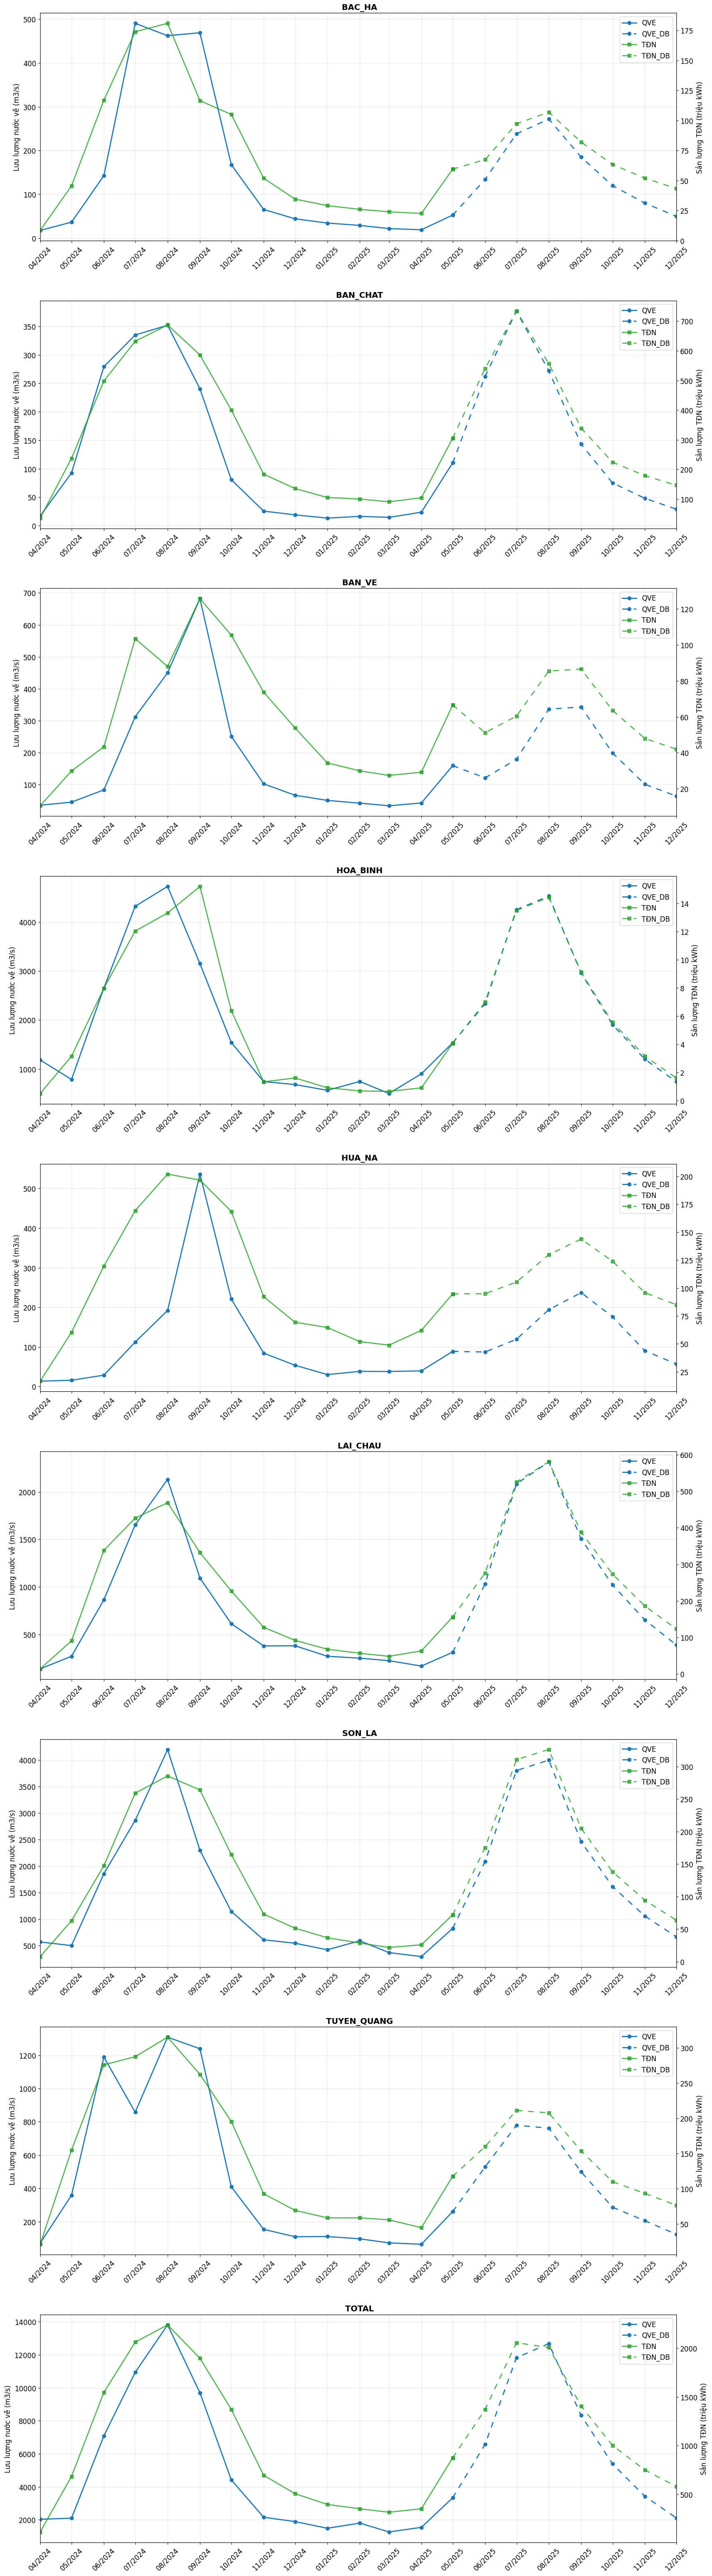


Đã vẽ biểu đồ lịch sử và dự báo cho 9 giá trị TD_THAMCHIEU
Biểu đồ đã được lưu thành công vào file 'output/QVE_SL_forecast_plots.pdf'


In [14]:
# Kiểm tra sự tồn tại của cả hai DataFrame cần thiết
if 'result_with_total' in locals() and 'final_predictions_with_total' in locals():
    unique_td_thamchieu = result_with_total['TD_THAMCHIEU'].unique()
    print(f"Vẽ biểu đồ lịch sử và dự báo cho các TD_THAMCHIEU: {unique_td_thamchieu}")
    
    n_plots = len(unique_td_thamchieu)
    fig, axes = plt.subplots(n_plots, 1, figsize=(18, 7 * n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    # Lặp qua từng TD_THAMCHIEU
    for i, td_value in enumerate(unique_td_thamchieu):
        # --- 1. XỬ LÝ VÀ VẼ DỮ LIỆU LỊCH SỬ (như cũ) ---
        subset_data = result_with_total[result_with_total['TD_THAMCHIEU'] == td_value].copy()
        
        monthly_data = subset_data.groupby('Tháng').agg({
            'QVE': 'mean',
            'SL': 'sum'
        }).reset_index()
        
        monthly_data['Tháng'] = monthly_data['Tháng'].dt.start_time
        
        ax1 = axes[i]
        
        # Vẽ QVE lịch sử
        color_qve_hist = 'tab:blue'
        ax1.set_ylabel('Lưu lượng nước về (m3/s)', color='black')
        line1 = ax1.plot(monthly_data['Tháng'], monthly_data['QVE'], 
                        color=color_qve_hist, linewidth=2, marker='o', label='QVE',
                        linestyle='-')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, alpha=0.3)
        
        # Vẽ SL lịch sử trên trục thứ hai
        ax2 = ax1.twinx()
        color_sl_hist = 'tab:green'
        ax2.set_ylabel('Sản lượng TĐN (triệu kWh)', color='black')
        line2 = ax2.plot(monthly_data['Tháng'], monthly_data['SL'], 
                        color=color_sl_hist, linewidth=2, marker='s', 
                        linestyle='-', label='SL_TĐN', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor='black')

        # --- 2. XỬ LÝ VÀ VẼ BỔ SUNG DỮ LIỆU DỰ BÁO ---
        forecast_subset = final_predictions_with_total[final_predictions_with_total['TD_THAMCHIEU'] == td_value].copy()
        
        if not forecast_subset.empty:
            forecast_subset['Tháng'] = pd.to_datetime(forecast_subset['Tháng'])
            last_hist_point = monthly_data.iloc[-1:]
            
            plot_forecast_qve = pd.concat([last_hist_point[['Tháng', 'QVE']].rename(columns={'QVE':'QVE_dubao'}), forecast_subset[['Tháng', 'QVE_dubao']]])
            plot_forecast_sl = pd.concat([last_hist_point[['Tháng', 'SL']].rename(columns={'SL':'SL_dubao'}), forecast_subset[['Tháng', 'SL_dubao']]])
            
            ax1.plot(plot_forecast_qve['Tháng'], plot_forecast_qve['QVE_dubao'], 
                     color=color_qve_hist, linewidth=2, marker='o', label='QVE_DB',
                     linestyle='--', dashes=(5, 5))  # Thêm dashes để điều chỉnh độ thưa

            ax2.plot(plot_forecast_sl['Tháng'], plot_forecast_sl['SL_dubao'], 
                     color=color_sl_hist, linewidth=2, marker='s', linestyle='--', 
                     label='SL_DB', alpha=0.8, dashes=(5, 5))  # Thêm dashes để điều chỉnh độ thưa
            
            ax1.set_xlim(monthly_data['Tháng'].min(), forecast_subset['Tháng'].max())
        else:
            ax1.set_xlim(monthly_data['Tháng'].min(), monthly_data['Tháng'].max())

        ax1.set_title(f' {td_value}', fontsize=14, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        
        # Vẽ legend với 4 đường riêng biệt
        ax1.legend(lines1 + lines2, 
                  ['QVE', 'QVE_DB', 'TĐN', 'TĐN_DB'],  # Đổi tên nhãn cho phù hợp
                  loc='upper right', 
                  fontsize=12,
                  frameon=True)
        
        ax1.tick_params(axis='x', rotation=45, labelcolor='black')
        
        from matplotlib.dates import DateFormatter, MonthLocator
        ax1.xaxis.set_major_locator(MonthLocator(interval=1))
        date_formatter = DateFormatter('%m/%Y')
        ax1.xaxis.set_major_formatter(date_formatter)
        
        print(f"- {td_value}: {len(monthly_data)} tháng lịch sử, {len(forecast_subset)} tháng dự báo.")
    
    plt.tight_layout(pad=3.0)
    
    # Hiển thị biểu đồ
    plt.show()
    
    # Lưu biểu đồ với chất lượng cao
    fig.savefig('bieudu_output/QVE_SL_forecast_plots.pdf', 
                format='pdf',
                dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    
    print(f"\nĐã vẽ biểu đồ lịch sử và dự báo cho {n_plots} giá trị TD_THAMCHIEU")
    print("Biểu đồ đã được lưu thành công vào file 'output/QVE_SL_forecast_plots.pdf'")
    
else:
    print("Chưa có đủ dữ liệu. Vui lòng chạy các cell đọc 'result_with_total' và tính toán 'final_predictions_with_total' trước!")

Các giá trị unique của TD_THAMCHIEU: ['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG']


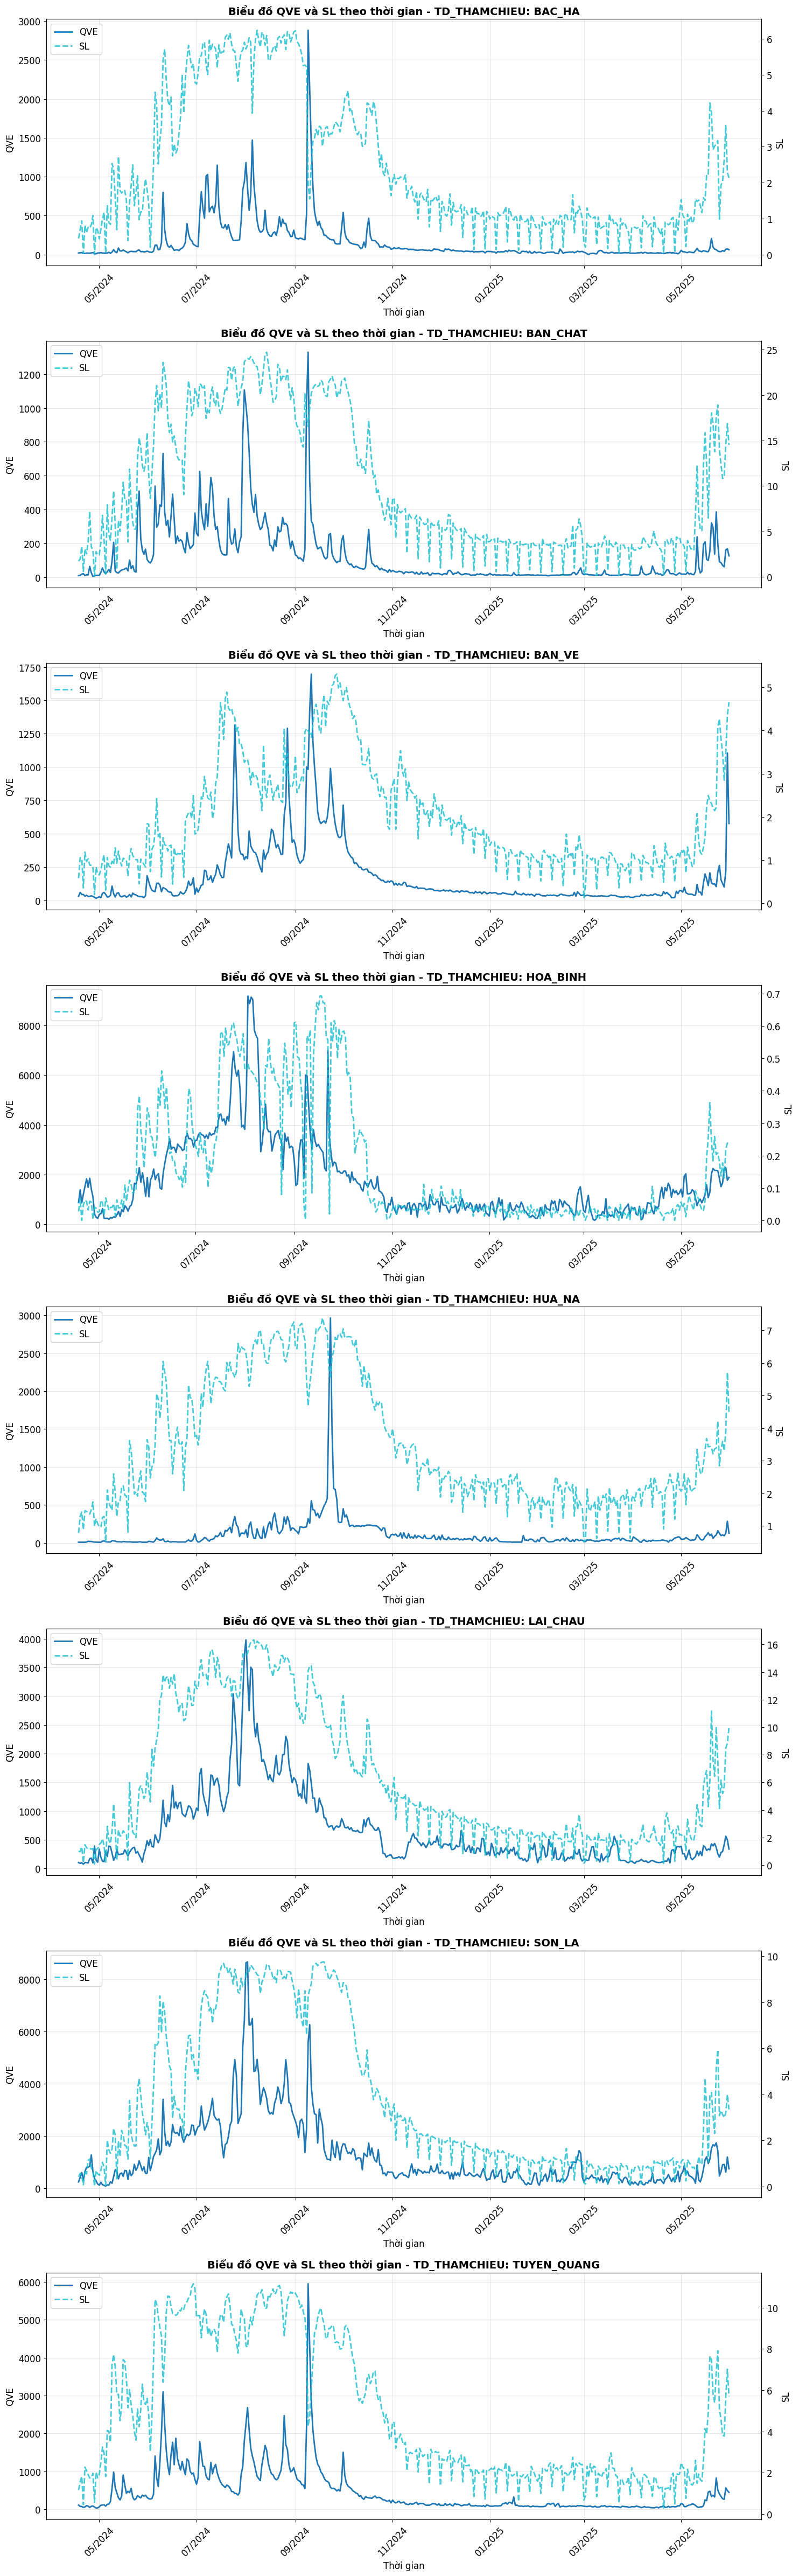


Đã vẽ 8 biểu đồ cho các giá trị TD_THAMCHIEU khác nhau


In [23]:

if 'data' in locals():
    unique_td_thamchieu = data['TD_THAMCHIEU'].unique()
    print(f"Các giá trị unique của TD_THAMCHIEU: {unique_td_thamchieu}")
    
    n_plots = len(unique_td_thamchieu)
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for i, td_value in enumerate(unique_td_thamchieu):
        subset_data = data[data['TD_THAMCHIEU'] == td_value].copy()
        
        if 'Ngày' in subset_data.columns:
            subset_data['Ngày'] = pd.to_datetime(subset_data['Ngày'])
            subset_data = subset_data.sort_values('Ngày')
            x_axis = subset_data['Ngày']
            x_label = 'Thời gian'
        elif 'NGAY' in subset_data.columns:
            subset_data['NGAY'] = pd.to_datetime(subset_data['NGAY'])
            subset_data = subset_data.sort_values('NGAY')
            x_axis = subset_data['NGAY']
            x_label = 'Thời gian'
        else:
            x_axis = range(len(subset_data))
            x_label = 'Chỉ số'
        
        ax1 = axes[i]
        
        color_qve = 'tab:blue'
        ax1.set_xlabel(x_label)
        ax1.set_ylabel('QVE', color='black')
        line1 = ax1.plot(x_axis, subset_data['QVE'], color=color_qve, linewidth=2, label='QVE')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, alpha=0.3)
        
        ax2 = ax1.twinx()
        color_sl = 'tab:cyan'
        ax2.set_ylabel('SL', color='black')
        line2 = ax2.plot(x_axis, subset_data['SL'], color=color_sl, linewidth=2, 
                        linestyle='--', label='SL', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor='black')
        
        ax1.set_title(f'Biểu đồ QVE và SL theo thời gian - TD_THAMCHIEU: {td_value}', 
                     fontsize=14, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        if 'Ngày' in subset_data.columns or 'NGAY' in subset_data.columns:
            ax1.tick_params(axis='x', rotation=45, labelcolor='black')
            
            from matplotlib.dates import DateFormatter
            date_formatter = DateFormatter('%m/%Y')
            ax1.xaxis.set_major_formatter(date_formatter)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nĐã vẽ {n_plots} biểu đồ cho các giá trị TD_THAMCHIEU khác nhau")
    
else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")

Vẽ biểu đồ theo tuần cho các giá trị TD_THAMCHIEU: ['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG']
- BAC_HA: 59 tuần dữ liệu
- BAN_CHAT: 59 tuần dữ liệu
- BAN_VE: 59 tuần dữ liệu
- HOA_BINH: 59 tuần dữ liệu
- HUA_NA: 59 tuần dữ liệu
- LAI_CHAU: 59 tuần dữ liệu
- SON_LA: 59 tuần dữ liệu
- TUYEN_QUANG: 59 tuần dữ liệu


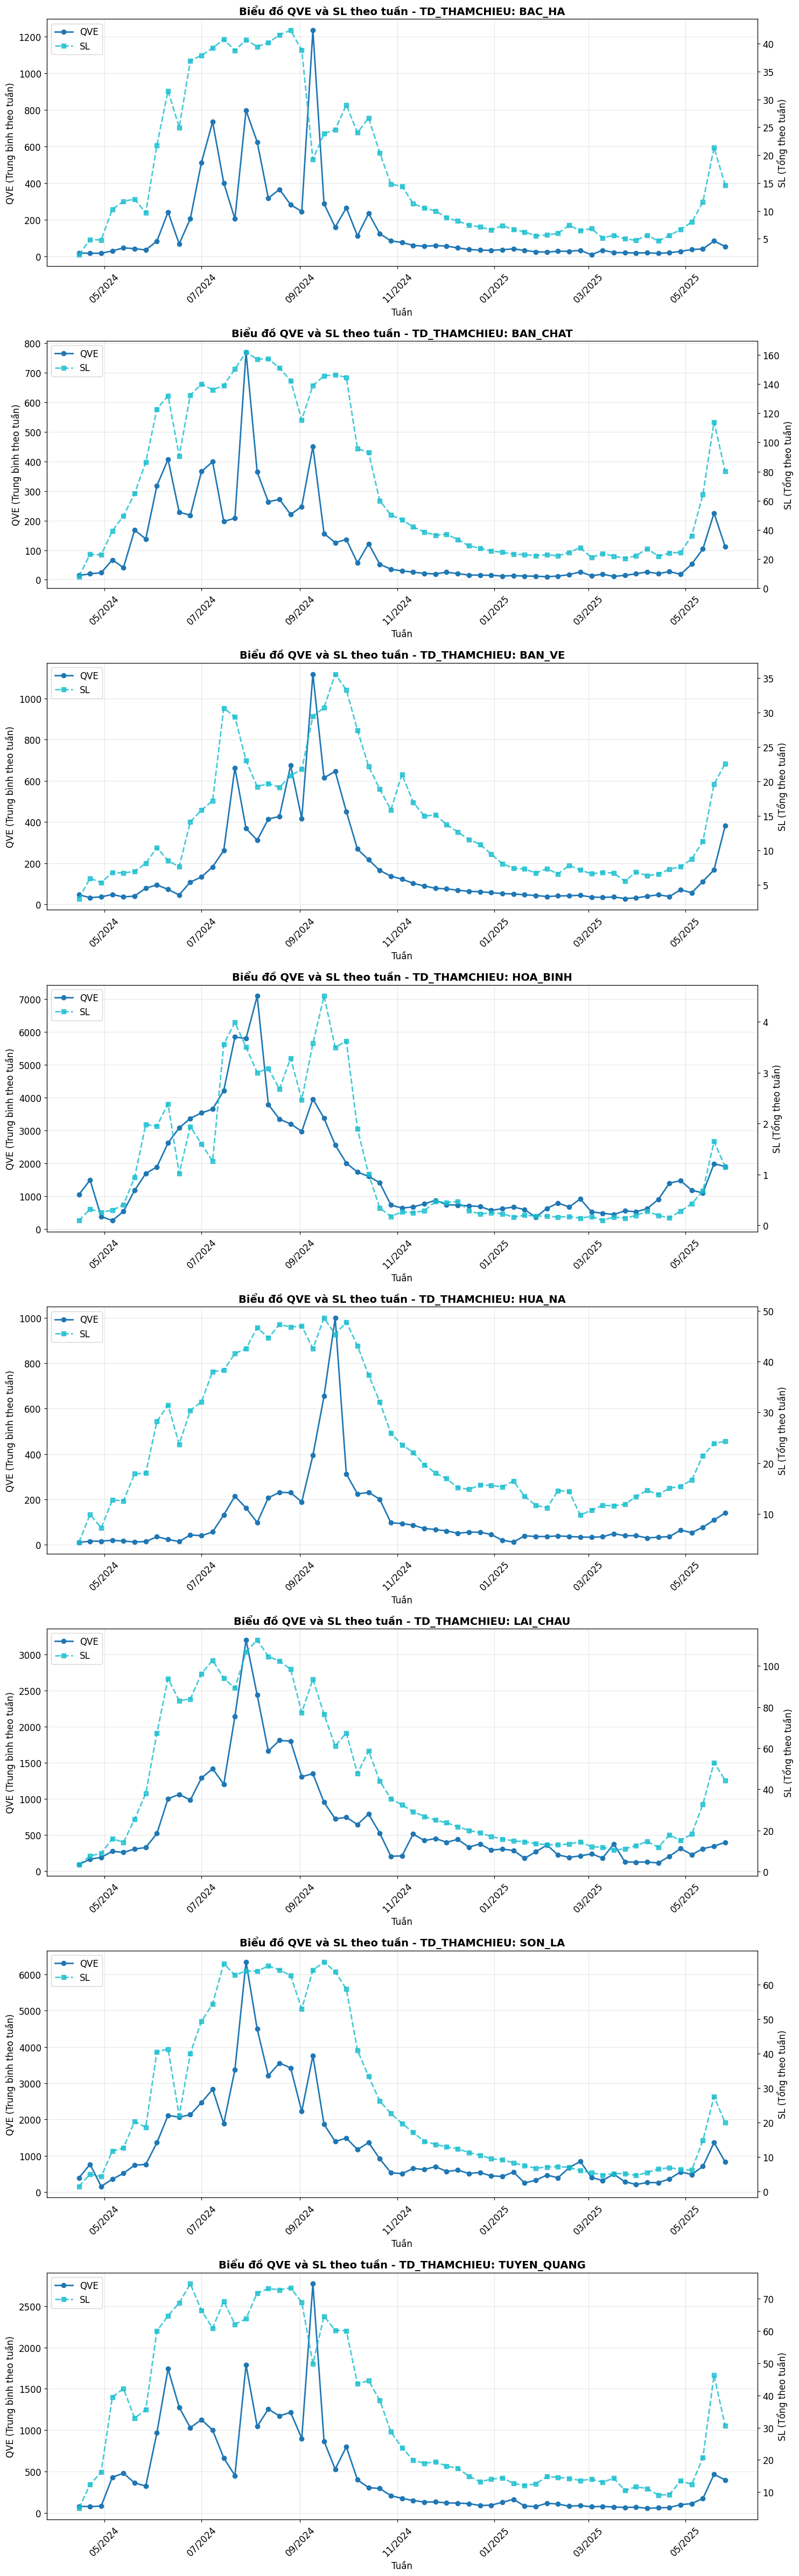


Đã vẽ biểu đồ theo tuần cho 8 giá trị TD_THAMCHIEU


In [13]:
if 'data' in locals():
    unique_td_thamchieu = data['TD_THAMCHIEU'].unique()
    print(f"Vẽ biểu đồ theo tuần cho các giá trị TD_THAMCHIEU: {unique_td_thamchieu}")
    
    n_plots = len(unique_td_thamchieu)
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for i, td_value in enumerate(unique_td_thamchieu):
        subset_data = data[data['TD_THAMCHIEU'] == td_value].copy()
        
        if 'Ngày' in subset_data.columns:
            date_col = 'Ngày'
        elif 'NGAY' in subset_data.columns:
            date_col = 'NGAY'
        else:
            print(f"Không tìm thấy cột ngày cho {td_value}")
            continue
            
        subset_data[date_col] = pd.to_datetime(subset_data[date_col])
        subset_data = subset_data.sort_values(date_col)
        
        subset_data['Tuần'] = subset_data[date_col].dt.to_period('W')
        
        weekly_data = subset_data.groupby('Tuần').agg({
            'QVE': 'mean',
            'SL': 'sum'
        }).reset_index()
        
        weekly_data['Tuần'] = weekly_data['Tuần'].dt.start_time
        
        ax1 = axes[i]
        
        color_qve = 'tab:blue'
        ax1.set_xlabel('Tuần')
        ax1.set_ylabel('QVE (Trung bình theo tuần)', color='black')
        line1 = ax1.plot(weekly_data['Tuần'], weekly_data['QVE'], 
                        color=color_qve, linewidth=2, marker='o', label='QVE')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, alpha=0.3)
        
        ax2 = ax1.twinx()
        color_sl = 'tab:cyan'
        ax2.set_ylabel('SL (Tổng theo tuần)', color='black')
        line2 = ax2.plot(weekly_data['Tuần'], weekly_data['SL'], 
                        color=color_sl, linewidth=2, marker='s', 
                        linestyle='--', label='SL', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor='black')
        
        ax1.set_title(f'Biểu đồ QVE và SL theo tuần - TD_THAMCHIEU: {td_value}', 
                     fontsize=14, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        ax1.tick_params(axis='x', rotation=45, labelcolor='black')
        
        from matplotlib.dates import DateFormatter
        date_formatter = DateFormatter('%m/%Y')
        ax1.xaxis.set_major_formatter(date_formatter)
        
        print(f"- {td_value}: {len(weekly_data)} tuần dữ liệu")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nĐã vẽ biểu đồ theo tuần cho {n_plots} giá trị TD_THAMCHIEU")
    
else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")


Vẽ biểu đồ lịch sử và dự báo cho các TD_THAMCHIEU: ['BAC_HA', 'BAN_CHAT', 'BAN_VE', 'HOA_BINH', 'HUA_NA', 'LAI_CHAU', 'SON_LA', 'TUYEN_QUANG', 'TOTAL']
- BAC_HA: 14 tháng lịch sử, 7 tháng dự báo.
- BAN_CHAT: 14 tháng lịch sử, 7 tháng dự báo.
- BAN_VE: 14 tháng lịch sử, 7 tháng dự báo.
- HOA_BINH: 14 tháng lịch sử, 7 tháng dự báo.
- HUA_NA: 14 tháng lịch sử, 7 tháng dự báo.
- LAI_CHAU: 14 tháng lịch sử, 7 tháng dự báo.
- SON_LA: 14 tháng lịch sử, 7 tháng dự báo.
- TUYEN_QUANG: 14 tháng lịch sử, 7 tháng dự báo.
- TOTAL: 7 tháng dự báo.


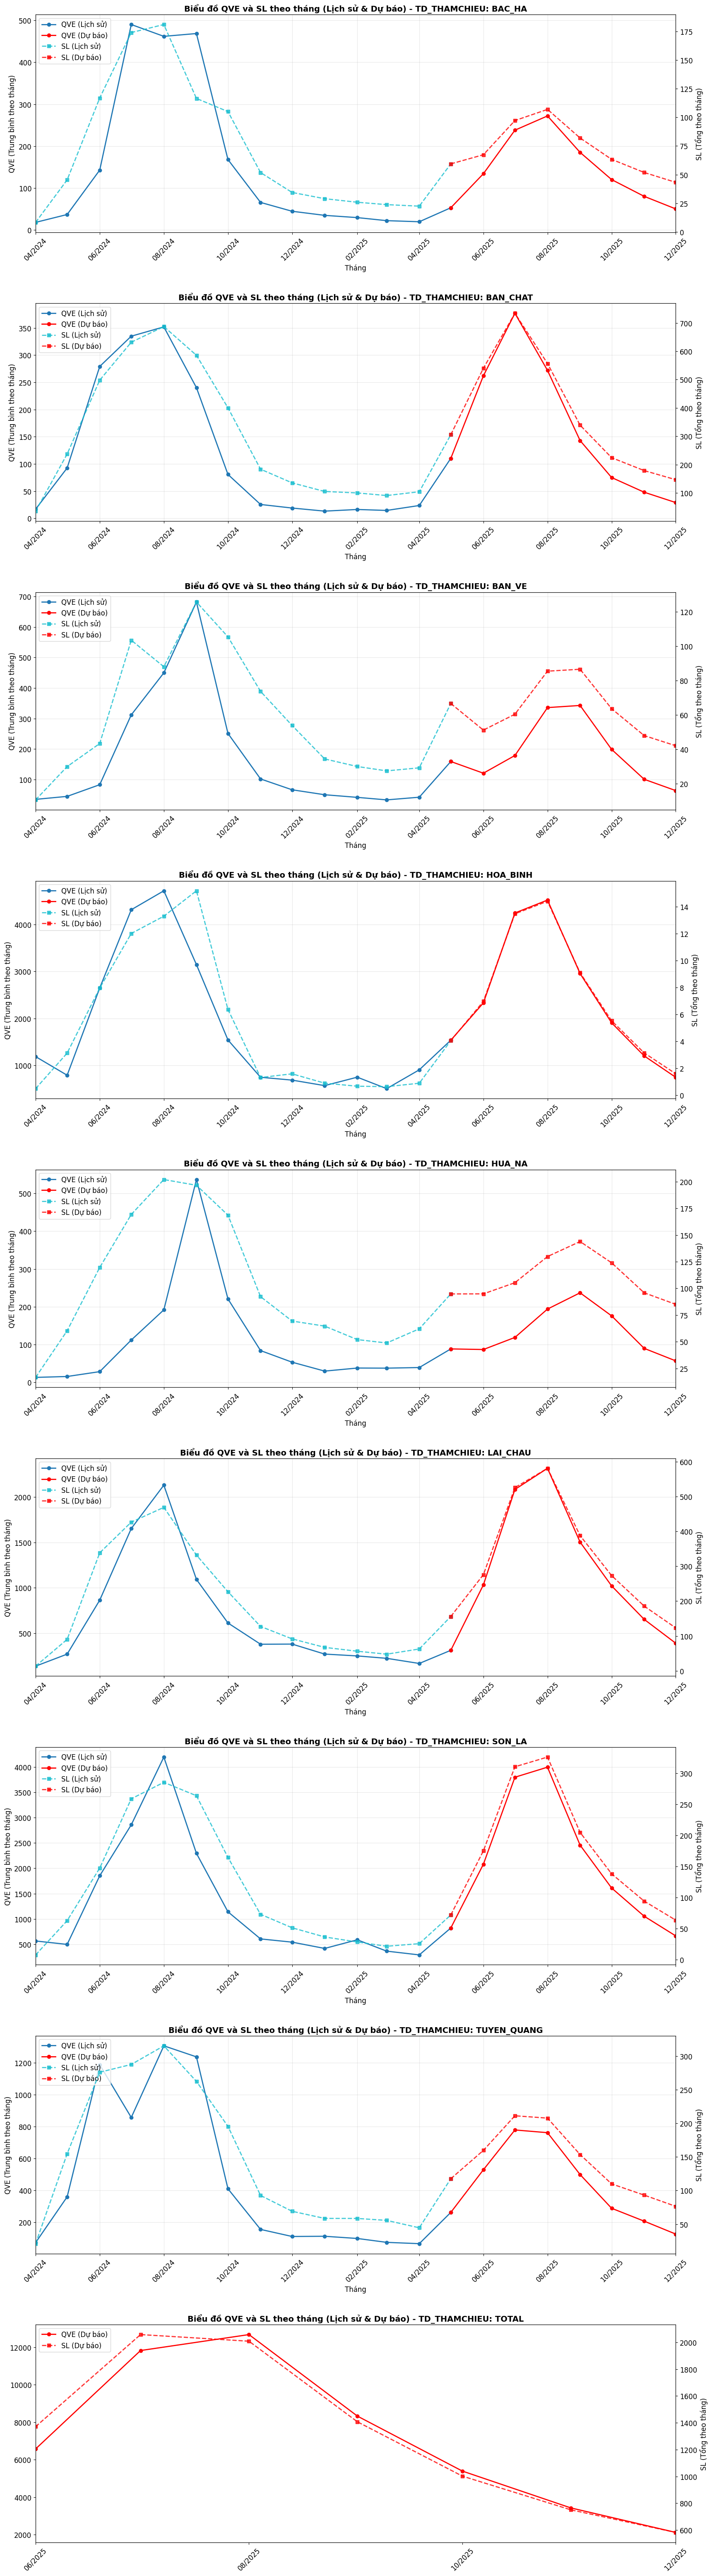


Đã vẽ biểu đồ lịch sử và dự báo cho 9 giá trị TD_THAMCHIEU


In [50]:
# Kiểm tra sự tồn tại của cả hai DataFrame cần thiết
if 'data' in locals() and 'final_predictions_with_total' in locals():
    # Lấy danh sách TD_THAMCHIEU từ data và thêm 'TOTAL' vào
    unique_td_thamchieu = list(data['TD_THAMCHIEU'].unique()) + ['TOTAL']
    print(f"Vẽ biểu đồ lịch sử và dự báo cho các TD_THAMCHIEU: {unique_td_thamchieu}")
    
    n_plots = len(unique_td_thamchieu)
    # Tăng chiều cao một chút để có thêm không gian cho chú thích
    fig, axes = plt.subplots(n_plots, 1, figsize=(18, 7 * n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    # Lặp qua từng TD_THAMCHIEU
    for i, td_value in enumerate(unique_td_thamchieu):
        ax1 = axes[i]
        
        if td_value != 'TOTAL':
            # --- 1. XỬ LÝ VÀ VẼ DỮ LIỆU LỊCH SỬ ---
            subset_data = data[data['TD_THAMCHIEU'] == td_value].copy()
            
            subset_data['Ngày'] = pd.to_datetime(subset_data['Ngày'])
            subset_data = subset_data.sort_values('Ngày')
            subset_data['Tháng'] = subset_data['Ngày'].dt.to_period('M')
            
            monthly_data = subset_data.groupby('Tháng').agg({
                'QVE': 'mean',
                'SL': 'sum'
            }).reset_index()
            
            monthly_data['Tháng'] = monthly_data['Tháng'].dt.start_time
            
            # Vẽ QVE lịch sử
            color_qve_hist = 'tab:blue'
            ax1.set_xlabel('Tháng')
            ax1.set_ylabel('QVE (Trung bình theo tháng)', color='black')
            line1 = ax1.plot(monthly_data['Tháng'], monthly_data['QVE'], 
                            color=color_qve_hist, linewidth=2, marker='o', label='QVE (Lịch sử)')
            ax1.tick_params(axis='y', labelcolor='black')
            ax1.grid(True, alpha=0.3)
            
            # Vẽ SL lịch sử trên trục thứ hai
            ax2 = ax1.twinx()
            color_sl_hist = 'tab:cyan'
            ax2.set_ylabel('SL (Tổng theo tháng)', color='black')
            line2 = ax2.plot(monthly_data['Tháng'], monthly_data['SL'], 
                            color=color_sl_hist, linewidth=2, marker='s', 
                            linestyle='--', label='SL (Lịch sử)', alpha=0.8)
            ax2.tick_params(axis='y', labelcolor='black')

        # --- 2. XỬ LÝ VÀ VẼ BỔ SUNG DỮ LIỆU DỰ BÁO ---
        forecast_subset = final_predictions_with_total[final_predictions_with_total['TD_THAMCHIEU'] == td_value].copy()
        
        if not forecast_subset.empty:
            # Chuyển cột Tháng (dạng string) sang datetime
            forecast_subset['Tháng'] = pd.to_datetime(forecast_subset['Tháng'])
            
            if td_value != 'TOTAL':
                # Để đường dự báo nối tiếp, ta cần điểm cuối của dữ liệu lịch sử
                last_hist_point = monthly_data.iloc[-1:]
                
                # Nối điểm cuối lịch sử vào đầu dữ liệu dự báo
                plot_forecast_qve = pd.concat([last_hist_point[['Tháng', 'QVE']].rename(columns={'QVE':'QVE_dubao'}), forecast_subset[['Tháng', 'QVE_dubao']]])
                plot_forecast_sl = pd.concat([last_hist_point[['Tháng', 'SL']].rename(columns={'SL':'SL_dubao'}), forecast_subset[['Tháng', 'SL_dubao']]])
            else:
                # Với TOTAL chỉ vẽ dữ liệu dự báo
                plot_forecast_qve = forecast_subset[['Tháng', 'QVE_dubao']]
                plot_forecast_sl = forecast_subset[['Tháng', 'SL_dubao']]
                
                # Tạo trục thứ hai cho TOTAL
                ax2 = ax1.twinx()
                ax2.set_ylabel('SL (Tổng theo tháng)', color='black')
                ax2.tick_params(axis='y', labelcolor='black')
            
            # Vẽ QVE dự báo (màu đỏ)
            ax1.plot(plot_forecast_qve['Tháng'], plot_forecast_qve['QVE_dubao'], 
                     color='red', linewidth=2, marker='o', label='QVE (Dự báo)')

            # Vẽ SL dự báo (màu đỏ)
            ax2.plot(plot_forecast_sl['Tháng'], plot_forecast_sl['SL_dubao'], 
                     color='red', linewidth=2, marker='s', linestyle='--', label='SL (Dự báo)', alpha=0.8)
            
            # Cập nhật giới hạn trục X
            if td_value != 'TOTAL':
                ax1.set_xlim(monthly_data['Tháng'].min(), forecast_subset['Tháng'].max())
            else:
                ax1.set_xlim(forecast_subset['Tháng'].min(), forecast_subset['Tháng'].max())
        else:
            # Nếu không có dự báo, chỉ giới hạn ở dữ liệu lịch sử
            ax1.set_xlim(monthly_data['Tháng'].min(), monthly_data['Tháng'].max())

        # --- 3. HOÀN THIỆN BIỂU ĐỒ ---
        ax1.set_title(f'Biểu đồ QVE và SL theo tháng (Lịch sử & Dự báo) - TD_THAMCHIEU: {td_value}', 
                     fontsize=14, fontweight='bold')
        
        # Tự động gộp legend từ cả hai trục
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        ax1.tick_params(axis='x', rotation=45, labelcolor='black')
        
        from matplotlib.dates import DateFormatter, MonthLocator
        ax1.xaxis.set_major_locator(MonthLocator(interval=2))
        date_formatter = DateFormatter('%m/%Y')
        ax1.xaxis.set_major_formatter(date_formatter)
        
        if td_value != 'TOTAL':
            print(f"- {td_value}: {len(monthly_data)} tháng lịch sử, {len(forecast_subset)} tháng dự báo.")
        else:
            print(f"- {td_value}: {len(forecast_subset)} tháng dự báo.")
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    print(f"\nĐã vẽ biểu đồ lịch sử và dự báo cho {n_plots} giá trị TD_THAMCHIEU")
    
else:
    print("Chưa có đủ dữ liệu. Vui lòng chạy các cell đọc 'data' và tính toán 'final_predictions_with_total' trước!")

Vẽ biểu đồ theo tháng cho các giá trị TD_THAMCHIEU: ['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG']
- BAC_HA: 14 tháng dữ liệu
- BAN_CHAT: 14 tháng dữ liệu
- BAN_VE: 14 tháng dữ liệu
- HOA_BINH: 14 tháng dữ liệu
- HUA_NA: 14 tháng dữ liệu
- LAI_CHAU: 14 tháng dữ liệu
- SON_LA: 14 tháng dữ liệu
- TUYEN_QUANG: 14 tháng dữ liệu


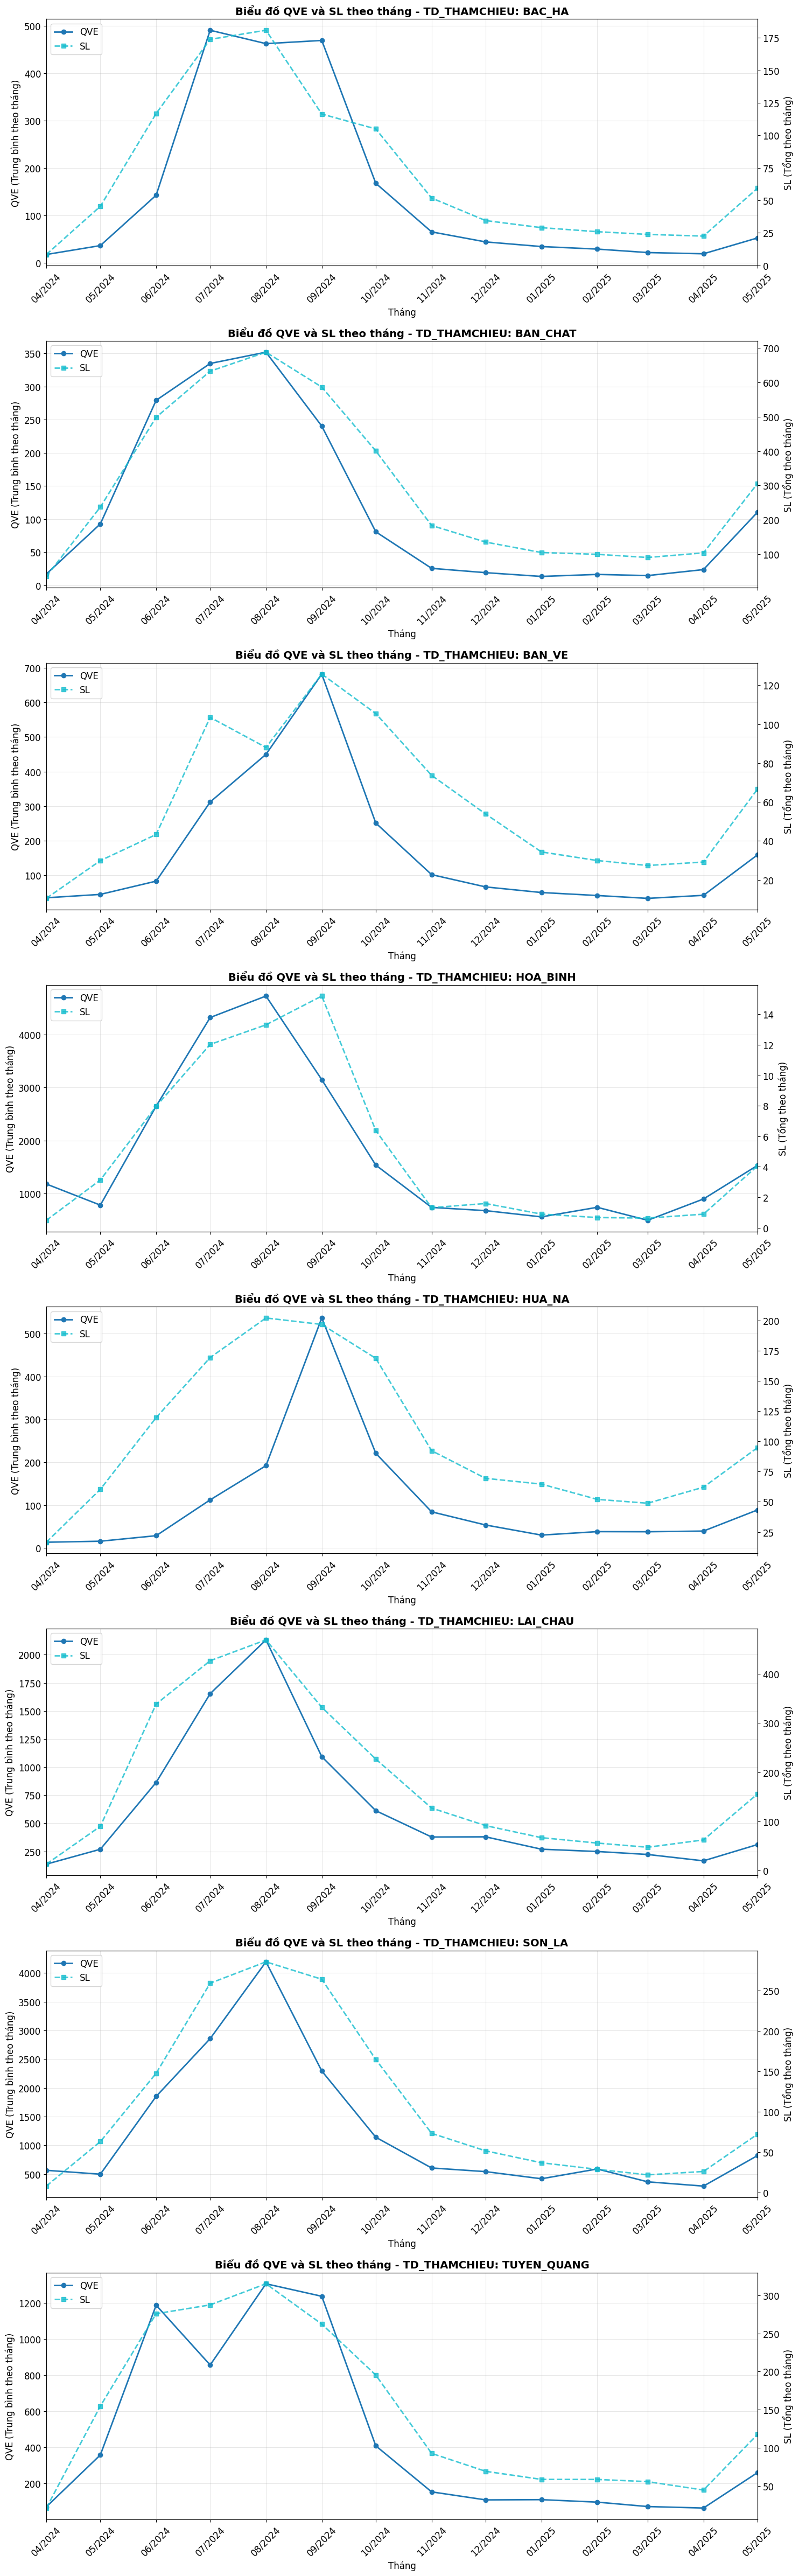


Đã vẽ biểu đồ theo tháng cho 8 giá trị TD_THAMCHIEU


In [24]:
if 'data' in locals():
    unique_td_thamchieu = data['TD_THAMCHIEU'].unique()
    print(f"Vẽ biểu đồ theo tháng cho các giá trị TD_THAMCHIEU: {unique_td_thamchieu}")
    
    n_plots = len(unique_td_thamchieu)
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for i, td_value in enumerate(unique_td_thamchieu):
        subset_data = data[data['TD_THAMCHIEU'] == td_value].copy()
        
        if 'Ngày' in subset_data.columns:
            date_col = 'Ngày'
        elif 'NGAY' in subset_data.columns:
            date_col = 'NGAY'
        else:
            print(f"Không tìm thấy cột ngày cho {td_value}")
            continue
            
        subset_data[date_col] = pd.to_datetime(subset_data[date_col])
        subset_data = subset_data.sort_values(date_col)
        
        subset_data['Tháng'] = subset_data[date_col].dt.to_period('M')
        
        monthly_data = subset_data.groupby('Tháng').agg({
            'QVE': 'mean',
            'SL': 'sum'
        }).reset_index()
        
        monthly_data['Tháng'] = monthly_data['Tháng'].dt.start_time
        
        ax1 = axes[i]
        
        color_qve = 'tab:blue'
        ax1.set_xlabel('Tháng')
        ax1.set_ylabel('QVE (Trung bình theo tháng)', color='black')
        line1 = ax1.plot(monthly_data['Tháng'], monthly_data['QVE'], 
                        color=color_qve, linewidth=2, marker='o', label='QVE')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, alpha=0.3)
        
        ax2 = ax1.twinx()
        color_sl = 'tab:cyan'
        ax2.set_ylabel('SL (Tổng theo tháng)', color='black')
        line2 = ax2.plot(monthly_data['Tháng'], monthly_data['SL'], 
                        color=color_sl, linewidth=2, marker='s', 
                        linestyle='--', label='SL', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor='black')
        
        ax1.set_title(f'Biểu đồ QVE và SL theo tháng - TD_THAMCHIEU: {td_value}', 
                     fontsize=14, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        ax1.tick_params(axis='x', rotation=45, labelcolor='black')
        
        from matplotlib.dates import DateFormatter, MonthLocator
        ax1.xaxis.set_major_locator(MonthLocator())
        date_formatter = DateFormatter('%m/%Y')
        ax1.xaxis.set_major_formatter(date_formatter)
        
        ax1.set_xlim(monthly_data['Tháng'].min(), monthly_data['Tháng'].max())
        
        print(f"- {td_value}: {len(monthly_data)} tháng dữ liệu")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nĐã vẽ biểu đồ theo tháng cho {n_plots} giá trị TD_THAMCHIEU")
    
else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")


In [14]:
import os

if 'data' in locals():
    output_dir = "bieudu_output"
    os.makedirs(output_dir, exist_ok=True)
    
    unique_td_thamchieu = data['TD_THAMCHIEU'].unique()
    
    print("Đang xuất biểu đồ theo ngày...")
    n_plots = len(unique_td_thamchieu)
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for i, td_value in enumerate(unique_td_thamchieu):
        subset_data = data[data['TD_THAMCHIEU'] == td_value].copy()
        
        if 'Ngày' in subset_data.columns:
            subset_data['Ngày'] = pd.to_datetime(subset_data['Ngày'])
            subset_data = subset_data.sort_values('Ngày')
            x_axis = subset_data['Ngày']
            x_label = 'Thời gian'
        elif 'NGAY' in subset_data.columns:
            subset_data['NGAY'] = pd.to_datetime(subset_data['NGAY'])
            subset_data = subset_data.sort_values('NGAY')
            x_axis = subset_data['NGAY']
            x_label = 'Thời gian'
        else:
            x_axis = range(len(subset_data))
            x_label = 'Chỉ số'
        
        ax1 = axes[i]
        
        color_qve = 'tab:blue'
        ax1.set_xlabel(x_label)
        ax1.set_ylabel('QVE', color='black')
        line1 = ax1.plot(x_axis, subset_data['QVE'], color=color_qve, linewidth=2, label='QVE')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, alpha=0.3)
        
        ax2 = ax1.twinx()
        color_sl = 'tab:cyan'
        ax2.set_ylabel('SL', color='black')
        line2 = ax2.plot(x_axis, subset_data['SL'], color=color_sl, linewidth=2, 
                        linestyle='--', label='SL', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor='black')
        
        ax1.set_title(f'Biểu đồ QVE và SL theo thời gian - TD_THAMCHIEU: {td_value}', 
                     fontsize=14, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        if 'Ngày' in subset_data.columns or 'NGAY' in subset_data.columns:
            ax1.tick_params(axis='x', rotation=45, labelcolor='black')
            
            from matplotlib.dates import DateFormatter
            date_formatter = DateFormatter('%m/%Y')
            ax1.xaxis.set_major_formatter(date_formatter)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/bieu_do_theo_ngay.png', dpi=300, bbox_inches='tight', 
                format='png', facecolor='white', edgecolor='none')
    plt.savefig(f'{output_dir}/bieu_do_theo_ngay.pdata', dpi=300, bbox_inches='tight', 
                format='pdata', facecolor='white', edgecolor='none')
    plt.close()
    
    print("Đang xuất biểu đồ theo tuần...")
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for i, td_value in enumerate(unique_td_thamchieu):
        subset_data = data[data['TD_THAMCHIEU'] == td_value].copy()
        
        if 'Ngày' in subset_data.columns:
            date_col = 'Ngày'
        elif 'NGAY' in subset_data.columns:
            date_col = 'NGAY'
        else:
            continue
            
        subset_data[date_col] = pd.to_datetime(subset_data[date_col])
        subset_data = subset_data.sort_values(date_col)
        
        subset_data['Tuần'] = subset_data[date_col].dt.to_period('W')
        
        weekly_data = subset_data.groupby('Tuần').agg({
            'QVE': 'mean',
            'SL': 'sum'
        }).reset_index()
        
        weekly_data['Tuần'] = weekly_data['Tuần'].dt.start_time
        
        ax1 = axes[i]
        
        color_qve = 'tab:blue'
        ax1.set_xlabel('Tuần')
        ax1.set_ylabel('QVE (Trung bình theo tuần)', color='black')
        line1 = ax1.plot(weekly_data['Tuần'], weekly_data['QVE'], 
                        color=color_qve, linewidth=2, marker='o', label='QVE')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, alpha=0.3)
        
        ax2 = ax1.twinx()
        color_sl = 'tab:cyan'
        ax2.set_ylabel('SL (Tổng theo tuần)', color='black')
        line2 = ax2.plot(weekly_data['Tuần'], weekly_data['SL'], 
                        color=color_sl, linewidth=2, marker='s', 
                        linestyle='--', label='SL', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor='black')
        
        ax1.set_title(f'Biểu đồ QVE và SL theo tuần - TD_THAMCHIEU: {td_value}', 
                     fontsize=14, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        ax1.tick_params(axis='x', rotation=45, labelcolor='black')
        
        from matplotlib.dates import DateFormatter
        date_formatter = DateFormatter('%m/%Y')
        ax1.xaxis.set_major_formatter(date_formatter)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/bieu_do_theo_tuan.png', dpi=300, bbox_inches='tight', 
                format='png', facecolor='white', edgecolor='none')
    plt.savefig(f'{output_dir}/bieu_do_theo_tuan.pdata', dpi=300, bbox_inches='tight', 
                format='pdata', facecolor='white', edgecolor='none')
    plt.close()
    
    print("Đang xuất biểu đồ theo tháng...")
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for i, td_value in enumerate(unique_td_thamchieu):
        subset_data = data[data['TD_THAMCHIEU'] == td_value].copy()
        
        if 'Ngày' in subset_data.columns:
            date_col = 'Ngày'
        elif 'NGAY' in subset_data.columns:
            date_col = 'NGAY'
        else:
            continue
            
        subset_data[date_col] = pd.to_datetime(subset_data[date_col])
        subset_data = subset_data.sort_values(date_col)
        
        subset_data['Tháng'] = subset_data[date_col].dt.to_period('M')
        
        monthly_data = subset_data.groupby('Tháng').agg({
            'QVE': 'mean',
            'SL': 'sum'
        }).reset_index()
        
        monthly_data['Tháng'] = monthly_data['Tháng'].dt.start_time
        
        ax1 = axes[i]
        
        color_qve = 'tab:blue'
        ax1.set_xlabel('Tháng')
        ax1.set_ylabel('QVE (Trung bình theo tháng)', color='black')
        line1 = ax1.plot(monthly_data['Tháng'], monthly_data['QVE'], 
                        color=color_qve, linewidth=2, marker='o', label='QVE')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, alpha=0.3)
        
        ax2 = ax1.twinx()
        color_sl = 'tab:cyan'
        ax2.set_ylabel('SL (Tổng theo tháng)', color='black')
        line2 = ax2.plot(monthly_data['Tháng'], monthly_data['SL'], 
                        color=color_sl, linewidth=2, marker='s', 
                        linestyle='--', label='SL', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor='black')
        
        ax1.set_title(f'Biểu đồ QVE và SL theo tháng - TD_THAMCHIEU: {td_value}', 
                     fontsize=14, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        ax1.tick_params(axis='x', rotation=45, labelcolor='black')
        
        from matplotlib.dates import DateFormatter, MonthLocator
        ax1.xaxis.set_major_locator(MonthLocator())
        date_formatter = DateFormatter('%m/%Y')
        ax1.xaxis.set_major_formatter(date_formatter)
        
        ax1.set_xlim(monthly_data['Tháng'].min(), monthly_data['Tháng'].max())
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/bieu_do_theo_thang.png', dpi=300, bbox_inches='tight', 
                format='png', facecolor='white', edgecolor='none')
    plt.savefig(f'{output_dir}/bieu_do_theo_thang.pdata', dpi=300, bbox_inches='tight', 
                format='pdata', facecolor='white', edgecolor='none')
    plt.close()
    
    print("\n✅ Hoàn thành xuất biểu đồ!")
    print(f"Các file đã được lưu trong thư mục: {output_dir}/")
    print("📁 Danh sách file:")
    print("   📊 bieu_do_theo_ngay.png (300 DPI)")
    print("   📊 bieu_do_theo_ngay.pdata (Vector)")
    print("   📊 bieu_do_theo_tuan.png (300 DPI)")
    print("   📊 bieu_do_theo_tuan.pdata (Vector)")
    print("   📊 bieu_do_theo_thang.png (300 DPI)")
    print("   📊 bieu_do_theo_thang.pdata (Vector)")
    
else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")


Đang xuất biểu đồ theo ngày...
Đang xuất biểu đồ theo tuần...
Đang xuất biểu đồ theo tháng...

✅ Hoàn thành xuất biểu đồ!
Các file đã được lưu trong thư mục: bieudu_output/
📁 Danh sách file:
   📊 bieu_do_theo_ngay.png (300 DPI)
   📊 bieu_do_theo_ngay.pdf (Vector)
   📊 bieu_do_theo_tuan.png (300 DPI)
   📊 bieu_do_theo_tuan.pdf (Vector)
   📊 bieu_do_theo_thang.png (300 DPI)
   📊 bieu_do_theo_thang.pdf (Vector)


Lọc dữ liệu tháng 9/2024...
✅ Tìm thấy dữ liệu tháng 9/2024 cho: ['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG']
Tổng số ngày: 240
Khoảng thời gian: 01/09/2024 - 30/09/2024
- BAC_HA: 30 ngày, tương quan QVE-SL = -0.561
- BAN_CHAT: 30 ngày, tương quan QVE-SL = -0.206
- BAN_VE: 30 ngày, tương quan QVE-SL = 0.237
- HOA_BINH: 30 ngày, tương quan QVE-SL = -0.177
- HUA_NA: 30 ngày, tương quan QVE-SL = -0.349
- LAI_CHAU: 30 ngày, tương quan QVE-SL = 0.772
- SON_LA: 30 ngày, tương quan QVE-SL = -0.156
- TUYEN_QUANG: 30 ngày, tương quan QVE-SL = -0.813


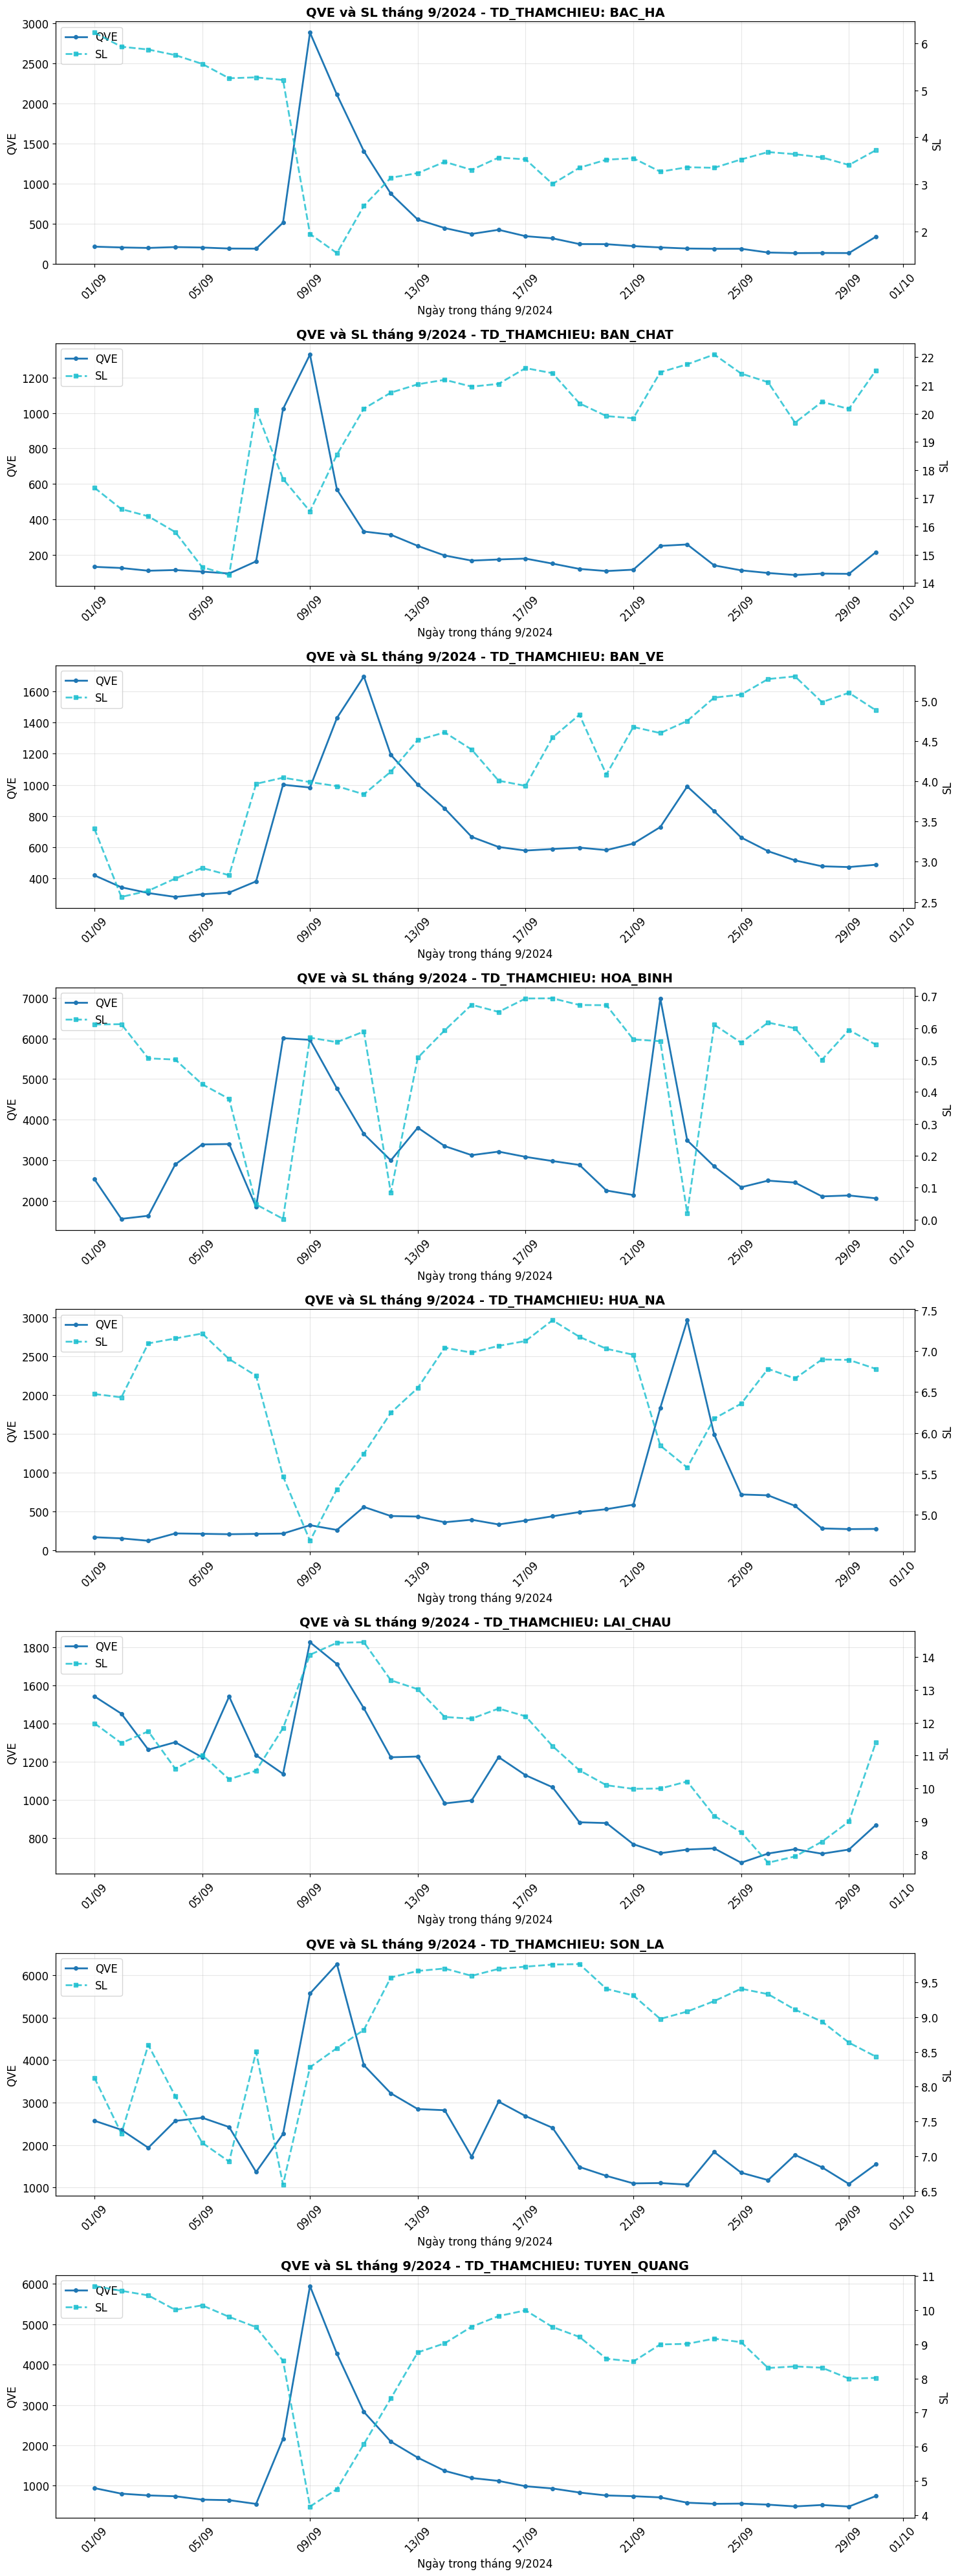


📊 Đã vẽ biểu đồ tháng 9/2024 cho 8 nhà máy
🔍 Chú ý: Dữ liệu ngắn hạn (1 tháng) có thể có biến động cao


In [15]:
if 'data' in locals():
    print("Lọc dữ liệu tháng 9/2024...")
    
    if 'Ngày' in data.columns:
        date_col = 'Ngày'
    elif 'NGAY' in data.columns:
        date_col = 'NGAY'
    else:
        print("Không tìm thấy cột ngày!")
        exit()
    
    data_copy = data.copy()
    data_copy[date_col] = pd.to_datetime(data_copy[date_col])
    
    sept_2024_data = data_copy[
        (data_copy[date_col].dt.year == 2024) & 
        (data_copy[date_col].dt.month == 9)
    ]
    
    if sept_2024_data.empty:
        print("❌ Không có dữ liệu cho tháng 9/2024!")
        print("Các năm có sẵn trong dữ liệu:")
        print(data_copy[date_col].dt.year.unique())
        print("Các tháng có sẵn trong dữ liệu:")
        print(data_copy[date_col].dt.month.unique())
    else:
        unique_td_thamchieu = sept_2024_data['TD_THAMCHIEU'].unique()
        print(f"✅ Tìm thấy dữ liệu tháng 9/2024 cho: {unique_td_thamchieu}")
        print(f"Tổng số ngày: {len(sept_2024_data)}")
        print(f"Khoảng thời gian: {sept_2024_data[date_col].min().strftime('%d/%m/%Y')} - {sept_2024_data[date_col].max().strftime('%d/%m/%Y')}")
        
        n_plots = len(unique_td_thamchieu)
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 5*n_plots))
        
        if n_plots == 1:
            axes = [axes]
        
        for i, td_value in enumerate(unique_td_thamchieu):
            subset_data = sept_2024_data[sept_2024_data['TD_THAMCHIEU'] == td_value].copy()
            subset_data = subset_data.sort_values(date_col)
            
            ax1 = axes[i] if n_plots > 1 else axes[0]
            
            color_qve = 'tab:blue'
            ax1.set_xlabel('Ngày trong tháng 9/2024')
            ax1.set_ylabel('QVE', color='black')
            line1 = ax1.plot(subset_data[date_col], subset_data['QVE'], 
                            color=color_qve, linewidth=2, marker='o', markersize=4, label='QVE')
            ax1.tick_params(axis='y', labelcolor='black')
            ax1.grid(True, alpha=0.3)
            
            ax2 = ax1.twinx()
            color_sl = 'tab:cyan'
            ax2.set_ylabel('SL', color='black')
            line2 = ax2.plot(subset_data[date_col], subset_data['SL'], 
                            color=color_sl, linewidth=2, marker='s', markersize=4,
                            linestyle='--', label='SL', alpha=0.8)
            ax2.tick_params(axis='y', labelcolor='black')
            
            ax1.set_title(f'QVE và SL tháng 9/2024 - TD_THAMCHIEU: {td_value}', 
                         fontsize=14, fontweight='bold')
            
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            
            ax1.tick_params(axis='x', rotation=45, labelcolor='black')
            
            from matplotlib.dates import DateFormatter
            date_formatter = DateFormatter('%d/%m')
            ax1.xaxis.set_major_formatter(date_formatter)
            
            correlation = subset_data['QVE'].corr(subset_data['SL'])
            print(f"- {td_value}: {len(subset_data)} ngày, tương quan QVE-SL = {correlation:.3f}")
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Đã vẽ biểu đồ tháng 9/2024 cho {len(unique_td_thamchieu)} nhà máy")
        print("🔍 Chú ý: Dữ liệu ngắn hạn (1 tháng) có thể có biến động cao")
        
else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")


In [16]:
import os

if 'data' in locals():
    print("Xuất biểu đồ tháng 9/2024 ra ảnh chất lượng cao...")
    
    output_dir = "bieudu_output"
    os.makedirs(output_dir, exist_ok=True)
    
    if 'Ngày' in data.columns:
        date_col = 'Ngày'
    elif 'NGAY' in data.columns:
        date_col = 'NGAY'
    else:
        print("Không tìm thấy cột ngày!")
        exit()
    
    data_copy = data.copy()
    data_copy[date_col] = pd.to_datetime(data_copy[date_col])
    
    sept_2024_data = data_copy[
        (data_copy[date_col].dt.year == 2024) & 
        (data_copy[date_col].dt.month == 9)
    ]
    
    if sept_2024_data.empty:
        print("❌ Không có dữ liệu cho tháng 9/2024!")
        print("Không thể xuất biểu đồ.")
    else:
        unique_td_thamchieu = sept_2024_data['TD_THAMCHIEU'].unique()
        print(f"Đang xuất biểu đồ cho {len(unique_td_thamchieu)} nhà máy...")
        
        n_plots = len(unique_td_thamchieu)
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 5*n_plots))
        
        if n_plots == 1:
            axes = [axes]
        
        for i, td_value in enumerate(unique_td_thamchieu):
            subset_data = sept_2024_data[sept_2024_data['TD_THAMCHIEU'] == td_value].copy()
            subset_data = subset_data.sort_values(date_col)
            
            ax1 = axes[i] if n_plots > 1 else axes[0]
            
            color_qve = 'tab:blue'
            ax1.set_xlabel('Ngày trong tháng 9/2024')
            ax1.set_ylabel('QVE', color='black')
            line1 = ax1.plot(subset_data[date_col], subset_data['QVE'], 
                            color=color_qve, linewidth=2, marker='o', markersize=4, label='QVE')
            ax1.tick_params(axis='y', labelcolor='black')
            ax1.grid(True, alpha=0.3)
            
            ax2 = ax1.twinx()
            color_sl = 'tab:cyan'
            ax2.set_ylabel('SL', color='black')
            line2 = ax2.plot(subset_data[date_col], subset_data['SL'], 
                            color=color_sl, linewidth=2, marker='s', markersize=4,
                            linestyle='--', label='SL', alpha=0.8)
            ax2.tick_params(axis='y', labelcolor='black')
            
            ax1.set_title(f'QVE và SL tháng 9/2024 - TD_THAMCHIEU: {td_value}', 
                         fontsize=14, fontweight='bold')
            
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            
            ax1.tick_params(axis='x', rotation=45, labelcolor='black')
            
            from matplotlib.dates import DateFormatter
            date_formatter = DateFormatter('%d/%m')
            ax1.xaxis.set_major_formatter(date_formatter)
            
            correlation = subset_data['QVE'].corr(subset_data['SL'])
            print(f"- {td_value}: {len(subset_data)} ngày, tương quan = {correlation:.3f}")
        
        plt.tight_layout()
        
        plt.savefig(f'{output_dir}/bieu_do_thang_09_2024.png', dpi=300, bbox_inches='tight', 
                    format='png', facecolor='white', edgecolor='none')
        plt.savefig(f'{output_dir}/bieu_do_thang_09_2024.pdata', dpi=300, bbox_inches='tight', 
                    format='pdata', facecolor='white', edgecolor='none')
        
        plt.close()
        
        print("\n✅ Hoàn thành xuất biểu đồ tháng 9/2024!")
        print(f"Các file đã được lưu trong thư mục: {output_dir}/")
        print("📁 Danh sách file:")
        print("   📊 bieu_do_thang_09_2024.png (300 DPI)")
        print("   📊 bieu_do_thang_09_2024.pdata (Vector)")
        print(f"\n📄 Đường dẫn đầy đủ:")
        print(f"   PNG: {os.path.abspath(f'{output_dir}/bieu_do_thang_09_2024.png')}")
        print(f"   Pdata: {os.path.abspath(f'{output_dir}/bieu_do_thang_09_2024.pdata')}")
        
        file_size_png = os.path.getsize(f'{output_dir}/bieu_do_thang_09_2024.png') / 1024 / 1024
        file_size_pdata = os.path.getsize(f'{output_dir}/bieu_do_thang_09_2024.pdata') / 1024 / 1024
        print(f"\n📦 Kích thước file:")
        print(f"   PNG: {file_size_png:.2f} MB")
        print(f"   Pdata: {file_size_pdata:.2f} MB")
        
else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")


Xuất biểu đồ tháng 9/2024 ra ảnh chất lượng cao...
Đang xuất biểu đồ cho 8 nhà máy...
- BAC_HA: 30 ngày, tương quan = -0.561
- BAN_CHAT: 30 ngày, tương quan = -0.206
- BAN_VE: 30 ngày, tương quan = 0.237
- HOA_BINH: 30 ngày, tương quan = -0.177
- HUA_NA: 30 ngày, tương quan = -0.349
- LAI_CHAU: 30 ngày, tương quan = 0.772
- SON_LA: 30 ngày, tương quan = -0.156
- TUYEN_QUANG: 30 ngày, tương quan = -0.813

✅ Hoàn thành xuất biểu đồ tháng 9/2024!
Các file đã được lưu trong thư mục: bieudu_output/
📁 Danh sách file:
   📊 bieu_do_thang_09_2024.png (300 DPI)
   📊 bieu_do_thang_09_2024.pdf (Vector)

📄 Đường dẫn đầy đủ:
   PNG: d:\Khuê\Khue\TDN\notebooks\bieudu_output\bieu_do_thang_09_2024.png
   PDF: d:\Khuê\Khue\TDN\notebooks\bieudu_output\bieu_do_thang_09_2024.pdf

📦 Kích thước file:
   PNG: 2.41 MB
   PDF: 0.04 MB


In [20]:
try:
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    print("✅ Thư viện python-docx đã có sẵn")
except ImportError:
    print("❌ Chưa có thư viện python-docx. Đang cài đặt...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-docx"])
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    print("✅ Đã cài đặt thành công python-docx")

import os
import tempfile
import time

if 'data' in locals():
    print("Tạo file Word chứa biểu đồ tháng 9/2024...")
    
    output_dir = "bieudu_output"
    os.makedirs(output_dir, exist_ok=True)
    
    if 'Ngày' in data.columns:
        date_col = 'Ngày'
    elif 'NGAY' in data.columns:
        date_col = 'NGAY'
    else:
        print("Không tìm thấy cột ngày!")
        exit()
    
    data_copy = data.copy()
    data_copy[date_col] = pd.to_datetime(data_copy[date_col])
    
    sept_2024_data = data_copy[
        (data_copy[date_col].dt.year == 2024) & 
        (data_copy[date_col].dt.month == 9)
    ]
    
    if sept_2024_data.empty:
        print("❌ Không có dữ liệu cho tháng 9/2024!")
        print("Không thể tạo file Word.")
    else:
        doc = Document()
        
        title = doc.add_heading('BÁO CÁO PHÂN TÍCH QVE VÀ SL THÁNG 9/2024', 0)
        title.alignment = WD_ALIGN_PARAGRAPH.CENTER
        
        doc.add_paragraph()
        intro = doc.add_paragraph('Báo cáo phân tích mối tương quan giữa QVE (Quá trình vận hành) và SL (Sản lượng) của các nhà máy thủy điện trong tháng 9/2024.')
        intro.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
        
        doc.add_paragraph()
        
        unique_td_thamchieu = sept_2024_data['TD_THAMCHIEU'].unique()
        
        summary_table = doc.add_table(rows=1, cols=4)
        summary_table.style = 'Table Grid'
        
        hdr_cells = summary_table.rows[0].cells
        hdr_cells[0].text = 'Nhà máy'
        hdr_cells[1].text = 'Số ngày'
        hdr_cells[2].text = 'Tương quan QVE-SL'
        hdr_cells[3].text = 'Đánh giá'
        
        correlations = {}
        
        temp_files = []
        
        for td_value in unique_td_thamchieu:
            subset_data = sept_2024_data[sept_2024_data['TD_THAMCHIEU'] == td_value].copy()
            subset_data = subset_data.sort_values(date_col)
            
            tmp_file = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
            temp_files.append(tmp_file.name)
            tmp_file.close()
            
            fig, ax1 = plt.subplots(figsize=(12, 6))
            
            color_qve = 'tab:blue'
            ax1.set_xlabel('Ngày trong tháng 9/2024', fontsize=12)
            ax1.set_ylabel('QVE', color='black', fontsize=12)
            line1 = ax1.plot(subset_data[date_col], subset_data['QVE'], 
                            color=color_qve, linewidth=2, marker='o', markersize=4, label='QVE')
            ax1.tick_params(axis='y', labelcolor='black')
            ax1.grid(True, alpha=0.3)
            
            ax2 = ax1.twinx()
            color_sl = 'tab:cyan'
            ax2.set_ylabel('SL', color='black', fontsize=12)
            line2 = ax2.plot(subset_data[date_col], subset_data['SL'], 
                            color=color_sl, linewidth=2, marker='s', markersize=4,
                            linestyle='--', label='SL', alpha=0.8)
            ax2.tick_params(axis='y', labelcolor='black')
            
            ax1.set_title(f'Biểu đồ QVE và SL tháng 9/2024 - {td_value}', 
                         fontsize=14, fontweight='bold')
            
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            
            ax1.tick_params(axis='x', rotation=45, labelcolor='black')
            
            from matplotlib.dates import DateFormatter
            date_formatter = DateFormatter('%d/%m')
            ax1.xaxis.set_major_formatter(date_formatter)
            
            plt.tight_layout()
            plt.savefig(tmp_file.name, dpi=300, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            plt.close(fig)
            plt.clf()
            
            time.sleep(0.1)
            
            correlation = subset_data['QVE'].corr(subset_data['SL'])
            correlations[td_value] = correlation
            
            doc.add_heading(f'{td_value}', level=1)
            
            doc.add_picture(tmp_file.name, width=Inches(6))
            
            stats_para = doc.add_paragraph()
            stats_para.add_run('Thống kê: ').bold = True
            stats_para.add_run(f'Số ngày có dữ liệu: {len(subset_data)}, ')
            stats_para.add_run(f'Hệ số tương quan QVE-SL: {correlation:.3f}')
            
            if correlation > 0.8:
                assessment = "Tương quan rất cao - Vận hành hiệu quả"
            elif correlation > 0.6:
                assessment = "Tương quan cao - Vận hành tốt"
            elif correlation > 0.4:
                assessment = "Tương quan trung bình - Cần cải thiện"
            else:
                assessment = "Tương quan thấp - Cần kiểm tra vận hành"
            
            assess_para = doc.add_paragraph()
            assess_para.add_run('Đánh giá: ').bold = True
            assess_para.add_run(assessment)
            
            doc.add_paragraph()
            
            row_cells = summary_table.add_row().cells
            row_cells[0].text = td_value
            row_cells[1].text = str(len(subset_data))
            row_cells[2].text = f'{correlation:.3f}'
            row_cells[3].text = assessment.split(' - ')[0]
            
            print(f"✅ Đã thêm {td_value} vào Word document")
        
        summary_heading = doc.paragraphs[2]
        summary_heading.clear()
        summary_heading.add_run('BẢNG TÓNG KẾT').bold = True
        summary_heading.alignment = WD_ALIGN_PARAGRAPH.CENTER
        
        doc.add_paragraph()
        conclusion = doc.add_heading('KẾT LUẬN', level=1)
        
        best_corr = max(correlations.values())
        worst_corr = min(correlations.values())
        best_plant = [k for k, v in correlations.items() if v == best_corr][0]
        worst_plant = [k for k, v in correlations.items() if v == worst_corr][0]
        
        doc.add_paragraph(f'• Nhà máy có tương quan cao nhất: {best_plant} ({best_corr:.3f})')
        doc.add_paragraph(f'• Nhà máy cần cải thiện: {worst_plant} ({worst_corr:.3f})')
        doc.add_paragraph(f'• Trung bình tương quan toàn hệ thống: {np.mean(list(correlations.values())):.3f}')
        
        footer = doc.add_paragraph()
        footer.add_run(f'Báo cáo được tạo tự động vào {pd.Timestamp.now().strftime("%d/%m/%Y %H:%M:%S")}').italic = True
        footer.alignment = WD_ALIGN_PARAGRAPH.RIGHT
        
        docx_path = f'{output_dir}/bao_cao_QVE_SL_thang_09_2024.docx'
        doc.save(docx_path)
        
        print("\n🧹 Dọn dẹp temporary files...")
        for temp_file in temp_files:
            try:
                time.sleep(0.1)
                os.unlink(temp_file)
                print(f"   ✅ Đã xóa {temp_file}")
            except OSError as e:
                print(f"   ⚠️ Không thể xóa {temp_file}: {e}")
        
        print("\n✅ Hoàn thành tạo file Word!")
        print(f"📄 File đã được lưu: {docx_path}")
        print(f"📊 Bao gồm {len(unique_td_thamchieu)} biểu đồ và bảng tổng kết")
        print(f"📁 Đường dẫn đầy đủ: {os.path.abspath(docx_path)}")
        
        file_size = os.path.getsize(docx_path) / 1024 / 1024
        print(f"📦 Kích thước file: {file_size:.2f} MB")
        
else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")


✅ Thư viện python-docx đã có sẵn
Tạo file Word chứa biểu đồ tháng 9/2024...
✅ Đã thêm BAC_HA vào Word document
✅ Đã thêm BAN_CHAT vào Word document
✅ Đã thêm BAN_VE vào Word document
✅ Đã thêm HOA_BINH vào Word document
✅ Đã thêm HUA_NA vào Word document
✅ Đã thêm LAI_CHAU vào Word document
✅ Đã thêm SON_LA vào Word document
✅ Đã thêm TUYEN_QUANG vào Word document

🧹 Dọn dẹp temporary files...
   ✅ Đã xóa C:\Users\khuenm\AppData\Local\Temp\tmpkrqn3lzg.png
   ✅ Đã xóa C:\Users\khuenm\AppData\Local\Temp\tmpz5834582.png
   ✅ Đã xóa C:\Users\khuenm\AppData\Local\Temp\tmp2mtqlrux.png
   ✅ Đã xóa C:\Users\khuenm\AppData\Local\Temp\tmpqwr44t7o.png
   ✅ Đã xóa C:\Users\khuenm\AppData\Local\Temp\tmp8x43iucc.png
   ✅ Đã xóa C:\Users\khuenm\AppData\Local\Temp\tmpkt1ym3ob.png
   ✅ Đã xóa C:\Users\khuenm\AppData\Local\Temp\tmpx7caely1.png
   ✅ Đã xóa C:\Users\khuenm\AppData\Local\Temp\tmp6zp7eoi5.png

✅ Hoàn thành tạo file Word!
📄 File đã được lưu: bieudu_output/bao_cao_QVE_SL_thang_09_2024.docx
📊 

<Figure size 1200x800 with 0 Axes>

In [ ]:
if 'data' in locals():
    print("📊 PHÂN TÍCH ĐA PHƯƠNG PHÁP TƯƠNG QUAN QVE-SL THEO NGÀY")
    print("=" * 60)
    
    if 'Ngày' in data.columns:
        date_col = 'Ngày'
    elif 'NGAY' in data.columns:
        date_col = 'NGAY'
    else:
        print("Không tìm thấy cột ngày!")
        exit()
    
    data_copy = data.copy()
    data_copy[date_col] = pd.to_datetime(data_copy[date_col])
    data_copy = data_copy.sort_values(date_col)
    
    unique_td_thamchieu = data_copy['TD_THAMCHIEU'].unique()
    
    def interpret_correlation(corr_value, method_name):
        """Đánh giá mức độ tương quan theo từng phương pháp"""
        abs_corr = abs(corr_value)
        if abs_corr >= 0.9:
            return "Rất mạnh (Excellent)"
        elif abs_corr >= 0.7:
            return "Mạnh (Strong)"
        elif abs_corr >= 0.5:
            return "Trung bình (Moderate)"
        elif abs_corr >= 0.3:
            return "Yếu (Weak)"
        else:
            return "Rất yếu (Very weak)"
    
    def calculate_lag_correlation(x, y, max_lag=7):
        """Tính tương quan với độ trễ để tìm lag tối ưu"""
        best_lag = 0
        best_corr = 0
        lag_results = {}
        
        for lag in range(-max_lag, max_lag + 1):
            if lag == 0:
                corr = x.corr(y)
            elif lag > 0:
                # QVE dẫn trước SL
                x_shifted = x[:-lag]
                y_shifted = y[lag:]
                if len(x_shifted) > 5:  # Đảm bảo đủ dữ liệu
                    corr = x_shifted.corr(y_shifted)
                else:
                    corr = 0
            else:
                # SL dẫn trước QVE
                lag = abs(lag)
                x_shifted = x[lag:]
                y_shifted = y[:-lag]
                if len(x_shifted) > 5:
                    corr = x_shifted.corr(y_shifted)
                else:
                    corr = 0
            
            lag_results[lag if lag >= 0 else lag] = corr
            if abs(corr) > abs(best_corr):
                best_corr = corr
                best_lag = lag if lag >= 0 else lag
        
        return best_lag, best_corr, lag_results
    
    # Tạo DataFrame tổng kết
    summary_data = []
    
    for td_value in unique_td_thamchieu:
        subset_data = data_copy[data_copy['TD_THAMCHIEU'] == td_value].copy()
        subset_data = subset_data.sort_values(date_col).reset_index(drop=True)
        
        if len(subset_data) < 10:
            print(f"⚠️ {td_value}: Không đủ dữ liệu (chỉ có {len(subset_data)} ngày)")
            continue
        
        qve_data = subset_data['QVE'].dropna()
        sl_data = subset_data['SL'].dropna()
        
        # Đảm bảo cùng index
        common_idx = qve_data.index.intersection(sl_data.index)
        qve_clean = qve_data.loc[common_idx]
        sl_clean = sl_data.loc[common_idx]
        
        if len(qve_clean) < 5:
            print(f"⚠️ {td_value}: Không đủ dữ liệu sau khi xử lý NaN")
            continue
        
        print(f"\n🏭 {td_value} (Số ngày: {len(qve_clean)})")
        print("-" * 50)
        
        # 1. Pearson Correlation (tuyến tính)
        pearson = qve_clean.corr(sl_clean, method='pearson')
        print(f"📈 Pearson (Tuyến tính):     {pearson:6.3f} - {interpret_correlation(pearson, 'Pearson')}")
        
        # 2. Spearman Correlation (đơn điệu)
        spearman = qve_clean.corr(sl_clean, method='spearman')
        print(f"📊 Spearman (Đơn điệu):      {spearman:6.3f} - {interpret_correlation(spearman, 'Spearman')}")
        
        # 3. Kendall Correlation (concordance)
        kendall = qve_clean.corr(sl_clean, method='kendall')
        print(f"🔄 Kendall (Concordance):    {kendall:6.3f} - {interpret_correlation(kendall, 'Kendall')}")
        
        # 4. Lag Correlation Analysis
        best_lag, best_corr, lag_results = calculate_lag_correlation(qve_clean, sl_clean, max_lag=7)
        
        if best_lag == 0:
            lag_desc = "Đồng thời (No lag)"
        elif best_lag > 0:
            lag_desc = f"QVE dẫn trước {best_lag} ngày"
        else:
            lag_desc = f"SL dẫn trước {abs(best_lag)} ngày"
        
        print(f"⏱️ Lag tối ưu:              {best_lag:6d} - {lag_desc}")
        print(f"📊 Tương quan lag tối ưu:   {best_corr:6.3f} - {interpret_correlation(best_corr, 'Lag')}")
        
        # Phân tích sự khác biệt
        diff_sp_pe = abs(spearman - pearson)
        if diff_sp_pe > 0.1:
            print(f"🔍 Chênh lệch Spearman-Pearson: {diff_sp_pe:.3f} (Có xu hướng phi tuyến)")
        
        # Tổng kết cho bảng
        summary_data.append({
            'Nhà máy': td_value,
            'Số ngày': len(qve_clean),
            'Pearson': pearson,
            'Spearman': spearman,
            'Kendall': kendall,
            'Best Lag': best_lag,
            'Lag Corr': best_corr,
            'Đánh giá chung': interpret_correlation(max(abs(pearson), abs(spearman), abs(best_corr)), 'Overall')
        })
    
    print("\n" + "=" * 80)
    print("📋 BẢNG TỔNG KẾT TƯƠNG QUAN")
    print("=" * 80)
    
    summary_data = pd.DataFrame(summary_data)
    if not summary_data.empty:
        print(summary_data.to_string(index=False, float_format='%.3f'))
        
        print(f"\n📊 THỐNG KÊ TỔNG THỂ:")
        print(f"   • Pearson trung bình:  {summary_data['Pearson'].mean():.3f}")
        print(f"   • Spearman trung bình: {summary_data['Spearman'].mean():.3f}")
        print(f"   • Kendall trung bình:  {summary_data['Kendall'].mean():.3f}")
        
        # Phân tích lag patterns
        lag_counts = summary_data['Best Lag'].value_counts().sort_index()
        print(f"\n⏱️ PHÂN TÍCH LAG PATTERNS:")
        for lag, count in lag_counts.items():
            if lag == 0:
                print(f"   • Lag {lag:2d} (Đồng thời):     {count} nhà máy")
            elif lag > 0:
                print(f"   • Lag +{lag} (QVE dẫn trước): {count} nhà máy")
            else:
                print(f"   • Lag {lag:2d} (SL dẫn trước):  {count} nhà máy")
        
        # Khuyến nghị
        print(f"\n💡 KHUYẾN NGHỊ:")
        
        # Nhà máy tốt nhất và cần cải thiện
        best_overall = summary_data.loc[summary_data['Lag Corr'].idxmax()]
        worst_overall = summary_data.loc[summary_data['Lag Corr'].idxmin()]
        
        print(f"   🏆 Tương quan tốt nhất: {best_overall['Nhà máy']} (Lag corr: {best_overall['Lag Corr']:.3f})")
        print(f"   ⚠️ Cần cải thiện:      {worst_overall['Nhà máy']} (Lag corr: {worst_overall['Lag Corr']:.3f})")
        
        # Phân tích xu hướng phi tuyến
        nonlinear_plants = summary_data[abs(summary_data['Spearman'] - summary_data['Pearson']) > 0.1]
        if not nonlinear_plants.empty:
            print(f"   🔄 Có xu hướng phi tuyến: {', '.join(nonlinear_plants['Nhà máy'].tolist())}")
        
        # Phân tích lag patterns
        if (summary_data['Best Lag'] != 0).any():
            lag_plants = summary_data[summary_data['Best Lag'] != 0]
            print(f"   ⏰ Có độ trễ đáng kể: {len(lag_plants)} nhà máy")
    
    else:
        print("❌ Không có dữ liệu đủ để phân tích!")

else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")

📊 PHÂN TÍCH ĐA PHƯƠNG PHÁP TƯƠNG QUAN QVE-SL THEO NGÀY

🏭 BAC_HA (Số ngày: 409)
--------------------------------------------------
📈 Pearson (Tuyến tính):      0.525 - Trung bình (Moderate)
📊 Spearman (Đơn điệu):       0.891 - Mạnh (Strong)
🔄 Kendall (Concordance):     0.704 - Mạnh (Strong)
⏱️ Lag tối ưu:                   0 - Đồng thời (No lag)
📊 Tương quan lag tối ưu:    0.525 - Trung bình (Moderate)
🔍 Chênh lệch Spearman-Pearson: 0.366 (Có xu hướng phi tuyến)

🏭 TUYEN_QUANG (Số ngày: 409)
--------------------------------------------------
📈 Pearson (Tuyến tính):      0.651 - Trung bình (Moderate)
📊 Spearman (Đơn điệu):       0.905 - Rất mạnh (Excellent)
🔄 Kendall (Concordance):     0.724 - Mạnh (Strong)
⏱️ Lag tối ưu:                   0 - Đồng thời (No lag)
📊 Tương quan lag tối ưu:    0.651 - Trung bình (Moderate)
🔍 Chênh lệch Spearman-Pearson: 0.254 (Có xu hướng phi tuyến)

🏭 SON_LA (Số ngày: 409)
--------------------------------------------------
📈 Pearson (Tuyến tính):      0.79

In [23]:
if 'data' in locals():
    print("📊 PHÂN TÍCH ĐA PHƯƠNG PHÁP TƯƠNG QUAN QVE-SL THEO TUẦN")
    print("=" * 65)
    
    if 'Ngày' in data.columns:
        date_col = 'Ngày'
    elif 'NGAY' in data.columns:
        date_col = 'NGAY'
    else:
        print("Không tìm thấy cột ngày!")
        exit()
    
    data_copy = data.copy()
    data_copy[date_col] = pd.to_datetime(data_copy[date_col])
    data_copy = data_copy.sort_values(date_col)
    
    unique_td_thamchieu = data_copy['TD_THAMCHIEU'].unique()
    
    def interpret_correlation_weekly(corr_value, method_name):
        """Đánh giá mức độ tương quan theo từng phương pháp - Weekly data"""
        abs_corr = abs(corr_value)
        if abs_corr >= 0.85:  # Tiêu chuẩn cao hơn cho weekly data
            return "Rất mạnh (Excellent)"
        elif abs_corr >= 0.65:
            return "Mạnh (Strong)"
        elif abs_corr >= 0.45:
            return "Trung bình (Moderate)"
        elif abs_corr >= 0.25:
            return "Yếu (Weak)"
        else:
            return "Rất yếu (Very weak)"
    
    def calculate_lag_correlation_weekly(x, y, max_lag=8):
        """Tính tương quan với độ trễ theo tuần để tìm lag tối ưu"""
        best_lag = 0
        best_corr = 0
        lag_results = {}
        
        for lag in range(-max_lag, max_lag + 1):
            if lag == 0:
                corr = x.corr(y)
            elif lag > 0:
                # QVE dẫn trước SL
                x_shifted = x[:-lag]
                y_shifted = y[lag:]
                if len(x_shifted) > 3:  # Ít nhất 3 tuần
                    corr = x_shifted.corr(y_shifted)
                else:
                    corr = 0
            else:
                # SL dẫn trước QVE
                lag = abs(lag)
                x_shifted = x[lag:]
                y_shifted = y[:-lag]
                if len(x_shifted) > 3:
                    corr = x_shifted.corr(y_shifted)
                else:
                    corr = 0
            
            lag_results[lag if lag >= 0 else lag] = corr
            if abs(corr) > abs(best_corr):
                best_corr = corr
                best_lag = lag if lag >= 0 else lag
        
        return best_lag, best_corr, lag_results
    
    # Tạo DataFrame tổng kết
    summary_data = []
    
    for td_value in unique_td_thamchieu:
        subset_data = data_copy[data_copy['TD_THAMCHIEU'] == td_value].copy()
        subset_data = subset_data.sort_values(date_col)
        
        if len(subset_data) < 14:  # Ít nhất 2 tuần dữ liệu
            print(f"⚠️ {td_value}: Không đủ dữ liệu (chỉ có {len(subset_data)} ngày)")
            continue
        
        # Group by week và tính toán
        subset_data['Tuần'] = subset_data[date_col].dt.to_period('W')
        
        weekly_data = subset_data.groupby('Tuần').agg({
            'QVE': 'mean',  # QVE trung bình theo tuần
            'SL': 'sum'     # SL tổng theo tuần
        }).reset_index()
        
        weekly_data['Tuần'] = weekly_data['Tuần'].dt.start_time
        weekly_data = weekly_data.sort_values('Tuần').reset_index(drop=True)
        
        if len(weekly_data) < 4:  # Ít nhất 4 tuần
            print(f"⚠️ {td_value}: Không đủ tuần dữ liệu (chỉ có {len(weekly_data)} tuần)")
            continue
        
        qve_weekly = weekly_data['QVE'].dropna()
        sl_weekly = weekly_data['SL'].dropna()
        
        # Đảm bảo cùng index
        common_idx = qve_weekly.index.intersection(sl_weekly.index)
        qve_clean = qve_weekly.loc[common_idx]
        sl_clean = sl_weekly.loc[common_idx]
        
        if len(qve_clean) < 3:
            print(f"⚠️ {td_value}: Không đủ dữ liệu sau khi xử lý NaN")
            continue
        
        print(f"\n🏭 {td_value} (Số tuần: {len(qve_clean)})")
        print("-" * 55)
        
        # 1. Pearson Correlation (tuyến tính)
        pearson = qve_clean.corr(sl_clean, method='pearson')
        print(f"📈 Pearson (Tuyến tính):       {pearson:6.3f} - {interpret_correlation_weekly(pearson, 'Pearson')}")
        
        # 2. Spearman Correlation (đơn điệu)
        spearman = qve_clean.corr(sl_clean, method='spearman')
        print(f"📊 Spearman (Đơn điệu):        {spearman:6.3f} - {interpret_correlation_weekly(spearman, 'Spearman')}")
        
        # 3. Kendall Correlation (concordance)
        kendall = qve_clean.corr(sl_clean, method='kendall')
        print(f"🔄 Kendall (Concordance):      {kendall:6.3f} - {interpret_correlation_weekly(kendall, 'Kendall')}")
        
        # 4. Lag Correlation Analysis (theo tuần)
        best_lag, best_corr, lag_results = calculate_lag_correlation_weekly(qve_clean, sl_clean, max_lag=6)
        
        if best_lag == 0:
            lag_desc = "Đồng thời (No lag)"
        elif best_lag > 0:
            lag_desc = f"QVE dẫn trước {best_lag} tuần"
        else:
            lag_desc = f"SL dẫn trước {abs(best_lag)} tuần"
        
        print(f"⏱️ Lag tối ưu (tuần):         {best_lag:6d} - {lag_desc}")
        print(f"📊 Tương quan lag tối ưu:     {best_corr:6.3f} - {interpret_correlation_weekly(best_corr, 'Lag')}")
        
        # Phân tích sự khác biệt
        diff_sp_pe = abs(spearman - pearson)
        if diff_sp_pe > 0.15:  # Threshold cao hơn cho weekly data
            print(f"🔍 Chênh lệch Spearman-Pearson: {diff_sp_pe:.3f} (Có xu hướng phi tuyến mạnh)")
        elif diff_sp_pe > 0.08:
            print(f"🔍 Chênh lệch Spearman-Pearson: {diff_sp_pe:.3f} (Có xu hướng phi tuyến nhẹ)")
        
        # Phân tích biến động
        qve_cv = qve_clean.std() / qve_clean.mean() if qve_clean.mean() != 0 else 0
        sl_cv = sl_clean.std() / sl_clean.mean() if sl_clean.mean() != 0 else 0
        print(f"📊 Hệ số biến động QVE:       {qve_cv:6.3f}")
        print(f"📊 Hệ số biến động SL:        {sl_cv:6.3f}")
        
        # Tổng kết cho bảng
        summary_data.append({
            'Nhà máy': td_value,
            'Số tuần': len(qve_clean),
            'Pearson': pearson,
            'Spearman': spearman,
            'Kendall': kendall,
            'Best Lag': best_lag,
            'Lag Corr': best_corr,
            'QVE CV': qve_cv,
            'SL CV': sl_cv,
            'Đánh giá chung': interpret_correlation_weekly(max(abs(pearson), abs(spearman), abs(best_corr)), 'Overall')
        })
    
    print("\n" + "=" * 95)
    print("📋 BẢNG TỔNG KẾT TƯƠNG QUAN THEO TUẦN")
    print("=" * 95)
    
    summary_data = pd.DataFrame(summary_data)
    if not summary_data.empty:
        # Format và hiển thị bảng
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(summary_data.to_string(index=False, float_format='%.3f'))
        
        print(f"\n📊 THỐNG KÊ TỔNG THỂ (THEO TUẦN):")
        print(f"   • Pearson trung bình:    {summary_data['Pearson'].mean():.3f} ± {summary_data['Pearson'].std():.3f}")
        print(f"   • Spearman trung bình:   {summary_data['Spearman'].mean():.3f} ± {summary_data['Spearman'].std():.3f}")
        print(f"   • Kendall trung bình:    {summary_data['Kendall'].mean():.3f} ± {summary_data['Kendall'].std():.3f}")
        print(f"   • Lag correlation TB:    {summary_data['Lag Corr'].mean():.3f} ± {summary_data['Lag Corr'].std():.3f}")
        
        # Phân tích lag patterns theo tuần
        lag_counts = summary_data['Best Lag'].value_counts().sort_index()
        print(f"\n⏱️ PHÂN TÍCH LAG PATTERNS (THEO TUẦN):")
        for lag, count in lag_counts.items():
            if lag == 0:
                print(f"   • Lag {lag:2d} (Đồng thời):       {count} nhà máy")
            elif lag > 0:
                print(f"   • Lag +{lag} (QVE dẫn trước):   {count} nhà máy")
            else:
                print(f"   • Lag {lag:2d} (SL dẫn trước):    {count} nhà máy")
        
        # So sánh với threshold chuẩn
        excellent_plants = summary_data[summary_data['Lag Corr'] >= 0.85]
        good_plants = summary_data[(summary_data['Lag Corr'] >= 0.65) & (summary_data['Lag Corr'] < 0.85)]
        moderate_plants = summary_data[(summary_data['Lag Corr'] >= 0.45) & (summary_data['Lag Corr'] < 0.65)]
        
        print(f"\n🏆 PHÂN LOẠI HIỆU SUẤT (THEO TUẦN):")
        print(f"   • Excellent (≥0.85):     {len(excellent_plants)} nhà máy")
        print(f"   • Good (0.65-0.85):      {len(good_plants)} nhà máy") 
        print(f"   • Moderate (0.45-0.65):  {len(moderate_plants)} nhà máy")
        print(f"   • Cần cải thiện (<0.45): {len(summary_data[summary_data['Lag Corr'] < 0.45])} nhà máy")
        
        # Khuyến nghị
        print(f"\n💡 KHUYẾN NGHỊ (DỰA TRÊN DỮ LIỆU TUẦN):")
        
        # Nhà máy tốt nhất và cần cải thiện
        best_overall = summary_data.loc[summary_data['Lag Corr'].idxmax()]
        worst_overall = summary_data.loc[summary_data['Lag Corr'].idxmin()]
        
        print(f"   🏆 Tương quan tốt nhất:  {best_overall['Nhà máy']} (Lag corr: {best_overall['Lag Corr']:.3f})")
        print(f"   ⚠️ Cần cải thiện:       {worst_overall['Nhà máy']} (Lag corr: {worst_overall['Lag Corr']:.3f})")
        
        # Phân tích xu hướng phi tuyến
        nonlinear_plants = summary_data[abs(summary_data['Spearman'] - summary_data['Pearson']) > 0.15]
        if not nonlinear_plants.empty:
            print(f"   🔄 Xu hướng phi tuyến mạnh: {', '.join(nonlinear_plants['Nhà máy'].tolist())}")
        
        # Phân tích biến động
        high_volatility = summary_data[(summary_data['QVE CV'] > 0.5) | (summary_data['SL CV'] > 0.5)]
        if not high_volatility.empty:
            print(f"   📊 Biến động cao:        {', '.join(high_volatility['Nhà máy'].tolist())}")
        
        # Phân tích lag patterns
        if (summary_data['Best Lag'] != 0).any():
            lag_plants = summary_data[summary_data['Best Lag'] != 0]
            avg_lag = lag_plants['Best Lag'].mean()
            print(f"   ⏰ Có độ trễ đáng kể:     {len(lag_plants)} nhà máy (TB: {avg_lag:.1f} tuần)")
        
        # So sánh với phân tích ngày (nếu có)
        print(f"\n🔍 NHẬN XÉT ĐẶC BIỆT CHO DỮ LIỆU TUẦN:")
        print(f"   • Dữ liệu tuần giảm noise, tăng độ tin cậy tương quan")
        print(f"   • Lag pattern theo tuần phản ánh chu kỳ vận hành dài hạn")
        print(f"   • Threshold đánh giá được điều chỉnh phù hợp với weekly aggregation")
        
    else:
        print("❌ Không có dữ liệu đủ để phân tích theo tuần!")

else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")

📊 PHÂN TÍCH ĐA PHƯƠNG PHÁP TƯƠNG QUAN QVE-SL THEO TUẦN

🏭 BAC_HA (Số tuần: 59)
-------------------------------------------------------
📈 Pearson (Tuyến tính):        0.667 - Mạnh (Strong)
📊 Spearman (Đơn điệu):         0.938 - Rất mạnh (Excellent)
🔄 Kendall (Concordance):       0.792 - Mạnh (Strong)
⏱️ Lag tối ưu (tuần):              0 - Đồng thời (No lag)
📊 Tương quan lag tối ưu:      0.667 - Mạnh (Strong)
🔍 Chênh lệch Spearman-Pearson: 0.271 (Có xu hướng phi tuyến mạnh)
📊 Hệ số biến động QVE:        1.505
📊 Hệ số biến động SL:         0.775

🏭 TUYEN_QUANG (Số tuần: 59)
-------------------------------------------------------
📈 Pearson (Tuyến tính):        0.794 - Mạnh (Strong)
📊 Spearman (Đơn điệu):         0.940 - Rất mạnh (Excellent)
🔄 Kendall (Concordance):       0.798 - Mạnh (Strong)
⏱️ Lag tối ưu (tuần):              0 - Đồng thời (No lag)
📊 Tương quan lag tối ưu:      0.794 - Mạnh (Strong)
🔍 Chênh lệch Spearman-Pearson: 0.147 (Có xu hướng phi tuyến nhẹ)
📊 Hệ số biến động QVE:   

In [13]:
if 'data' in locals():
    print("📊 PHÂN TÍCH ĐA PHƯƠNG PHÁP TƯƠNG QUAN QVE-SL THEO THÁNG")
    print("=" * 70)
    
    if 'Ngày' in data.columns:
        date_col = 'Ngày'
    elif 'NGAY' in data.columns:
        date_col = 'NGAY'
    else:
        print("Không tìm thấy cột ngày!")
        exit()
    
    data_copy = data.copy()
    data_copy[date_col] = pd.to_datetime(data_copy[date_col])
    data_copy = data_copy.sort_values(date_col)
    
    unique_td_thamchieu = data_copy['TD_THAMCHIEU'].unique()
    
    def interpret_correlation_monthly(corr_value, method_name):
        """Đánh giá mức độ tương quan theo từng phương pháp - Monthly data"""
        abs_corr = abs(corr_value)
        if abs_corr >= 0.80:  # Tiêu chuẩn thấp hơn do sample size nhỏ
            return "Rất mạnh (Excellent)"
        elif abs_corr >= 0.60:
            return "Mạnh (Strong)"
        elif abs_corr >= 0.40:
            return "Trung bình (Moderate)"
        elif abs_corr >= 0.20:
            return "Yếu (Weak)"
        else:
            return "Rất yếu (Very weak)"
    
    def calculate_lag_correlation_monthly(x, y, max_lag=12):
        """Tính tương quan với độ trễ theo tháng để tìm lag tối ưu"""
        best_lag = 0
        best_corr = 0
        lag_results = {}
        seasonal_lags = [0, 3, 6, 9, 12]  # Đặc biệt chú ý seasonal lags
        
        for lag in range(-max_lag, max_lag + 1):
            if lag == 0:
                corr = x.corr(y)
            elif lag > 0:
                # QVE dẫn trước SL
                x_shifted = x[:-lag]
                y_shifted = y[lag:]
                if len(x_shifted) > 2:  # Ít nhất 3 tháng
                    corr = x_shifted.corr(y_shifted)
                else:
                    corr = 0
            else:
                # SL dẫn trước QVE
                lag = abs(lag)
                x_shifted = x[lag:]
                y_shifted = y[:-lag]
                if len(x_shifted) > 2:
                    corr = x_shifted.corr(y_shifted)
                else:
                    corr = 0
            
            lag_results[lag if lag >= 0 else lag] = corr
            if abs(corr) > abs(best_corr):
                best_corr = corr
                best_lag = lag if lag >= 0 else lag
        
        return best_lag, best_corr, lag_results, seasonal_lags
    
    def analyze_seasonality(data_monthly, plant_name):
        """Phân tích tính mùa vụ của dữ liệu"""
        if len(data_monthly) < 12:
            return "Không đủ dữ liệu để phân tích mùa vụ"
        
        data_monthly['Month'] = data_monthly['Tháng'].dt.month
        monthly_avg_qve = data_monthly.groupby('Month')['QVE'].mean()
        monthly_avg_sl = data_monthly.groupby('Month')['SL'].mean()
        
        # Tính hệ số biến động theo tháng
        qve_seasonal_cv = monthly_avg_qve.std() / monthly_avg_qve.mean() if monthly_avg_qve.mean() != 0 else 0
        sl_seasonal_cv = monthly_avg_sl.std() / monthly_avg_sl.mean() if monthly_avg_sl.mean() != 0 else 0
        
        # Tìm tháng peak và trough
        qve_peak_month = monthly_avg_qve.idxmax()
        qve_trough_month = monthly_avg_qve.idxmin()
        sl_peak_month = monthly_avg_sl.idxmax()
        sl_trough_month = monthly_avg_sl.idxmin()
        
        return {
            'QVE_seasonal_CV': qve_seasonal_cv,
            'SL_seasonal_CV': sl_seasonal_cv,
            'QVE_peak_month': qve_peak_month,
            'QVE_trough_month': qve_trough_month,
            'SL_peak_month': sl_peak_month,
            'SL_trough_month': sl_trough_month
        }
    
    # Tạo DataFrame tổng kết
    summary_data = []
    seasonal_analysis = []
    
    for td_value in unique_td_thamchieu:
        subset_data = data_copy[data_copy['TD_THAMCHIEU'] == td_value].copy()
        subset_data = subset_data.sort_values(date_col)
        
        if len(subset_data) < 60:  # Ít nhất 2 tháng dữ liệu (60 ngày)
            print(f"⚠️ {td_value}: Không đủ dữ liệu (chỉ có {len(subset_data)} ngày)")
            continue
        
        # Group by month và tính toán
        subset_data['Tháng'] = subset_data[date_col].dt.to_period('M')
        
        monthly_data = subset_data.groupby('Tháng').agg({
            'QVE': 'mean',  # QVE trung bình theo tháng
            'SL': 'sum'     # SL tổng theo tháng
        }).reset_index()
        
        monthly_data['Tháng'] = monthly_data['Tháng'].dt.start_time
        monthly_data = monthly_data.sort_values('Tháng').reset_index(drop=True)
        
        if len(monthly_data) < 3:  # Ít nhất 3 tháng
            print(f"⚠️ {td_value}: Không đủ tháng dữ liệu (chỉ có {len(monthly_data)} tháng)")
            continue
        
        qve_monthly = monthly_data['QVE'].dropna()
        sl_monthly = monthly_data['SL'].dropna()
        
        # Đảm bảo cùng index
        common_idx = qve_monthly.index.intersection(sl_monthly.index)
        qve_clean = qve_monthly.loc[common_idx]
        sl_clean = sl_monthly.loc[common_idx]
        
        if len(qve_clean) < 3:
            print(f"⚠️ {td_value}: Không đủ dữ liệu sau khi xử lý NaN")
            continue
        
        print(f"\n🏭 {td_value} (Số tháng: {len(qve_clean)})")
        print("-" * 60)
        
        # 1. Pearson Correlation (tuyến tính)
        pearson = qve_clean.corr(sl_clean, method='pearson')
        print(f"📈 Pearson (Tuyến tính):         {pearson:6.3f} - {interpret_correlation_monthly(pearson, 'Pearson')}")
        
        # 2. Spearman Correlation (đơn điệu)
        spearman = qve_clean.corr(sl_clean, method='spearman')
        print(f"📊 Spearman (Đơn điệu):          {spearman:6.3f} - {interpret_correlation_monthly(spearman, 'Spearman')}")
        
        # 3. Kendall Correlation (concordance)
        kendall = qve_clean.corr(sl_clean, method='kendall')
        print(f"🔄 Kendall (Concordance):        {kendall:6.3f} - {interpret_correlation_monthly(kendall, 'Kendall')}")
        
        # 4. Lag Correlation Analysis (theo tháng)
        best_lag, best_corr, lag_results, seasonal_lags = calculate_lag_correlation_monthly(qve_clean, sl_clean, max_lag=min(12, len(qve_clean)//2))
        
        if best_lag == 0:
            lag_desc = "Đồng thời (No lag)"
        elif best_lag > 0:
            lag_desc = f"QVE dẫn trước {best_lag} tháng"
        else:
            lag_desc = f"SL dẫn trước {abs(best_lag)} tháng"
        
        print(f"⏱️ Lag tối ưu (tháng):          {best_lag:6d} - {lag_desc}")
        print(f"📊 Tương quan lag tối ưu:       {best_corr:6.3f} - {interpret_correlation_monthly(best_corr, 'Lag')}")
        
        # 5. Seasonal Analysis
        seasonal_info = analyze_seasonality(monthly_data, td_value)
        if isinstance(seasonal_info, dict):
            print(f"🌿 Biến động mùa vụ QVE:        {seasonal_info['QVE_seasonal_CV']:6.3f}")
            print(f"🌿 Biến động mùa vụ SL:         {seasonal_info['SL_seasonal_CV']:6.3f}")
            print(f"📅 Tháng QVE cao nhất:          {seasonal_info['QVE_peak_month']:6d}")
            print(f"📅 Tháng SL cao nhất:           {seasonal_info['SL_peak_month']:6d}")
            
            seasonal_analysis.append({
                'Nhà máy': td_value,
                **seasonal_info
            })
        else:
            print(f"🌿 Phân tích mùa vụ:            {seasonal_info}")
        
        # Phân tích sự khác biệt
        diff_sp_pe = abs(spearman - pearson)
        if diff_sp_pe > 0.20:  # Threshold cao hơn cho monthly data
            print(f"🔍 Chênh lệch Spearman-Pearson: {diff_sp_pe:.3f} (Xu hướng phi tuyến rất mạnh)")
        elif diff_sp_pe > 0.12:
            print(f"🔍 Chênh lệch Spearman-Pearson: {diff_sp_pe:.3f} (Xu hướng phi tuyến mạnh)")
        elif diff_sp_pe > 0.06:
            print(f"🔍 Chênh lệch Spearman-Pearson: {diff_sp_pe:.3f} (Xu hướng phi tuyến nhẹ)")
        
        # Phân tích biến động
        qve_cv = qve_clean.std() / qve_clean.mean() if qve_clean.mean() != 0 else 0
        sl_cv = sl_clean.std() / sl_clean.mean() if sl_clean.mean() != 0 else 0
        print(f"📊 Hệ số biến động QVE:         {qve_cv:6.3f}")
        print(f"📊 Hệ số biến động SL:          {sl_cv:6.3f}")
        
        # Phân tích xu hướng dài hạn
        if len(qve_clean) >= 6:
            from scipy import stats
            qve_trend = stats.linregress(range(len(qve_clean)), qve_clean)[0]
            sl_trend = stats.linregress(range(len(sl_clean)), sl_clean)[0]
            print(f"📈 Xu hướng QVE (slope):        {qve_trend:6.3f}")
            print(f"📈 Xu hướng SL (slope):         {sl_trend:6.3f}")
        else:
            qve_trend, sl_trend = 0, 0
        
        # Tổng kết cho bảng
        summary_data.append({
            'Nhà máy': td_value,
            'Số tháng': len(qve_clean),
            'Pearson': pearson,
            'Spearman': spearman,
            'Kendall': kendall,
            'Best Lag': best_lag,
            'Lag Corr': best_corr,
            'QVE CV': qve_cv,
            'SL CV': sl_cv,
            'QVE Trend': qve_trend,
            'SL Trend': sl_trend,
            'Đánh giá chung': interpret_correlation_monthly(max(abs(pearson), abs(spearman), abs(best_corr)), 'Overall')
        })
    
    print("\n" + "=" * 110)
    print("📋 BẢNG TỔNG KẾT TƯƠNG QUAN THEO THÁNG")
    print("=" * 110)
    
    summary_data = pd.DataFrame(summary_data)
    if not summary_data.empty:
        # Format và hiển thị bảng
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(summary_data.to_string(index=False, float_format='%.3f'))
        
        print(f"\n📊 THỐNG KÊ TỔNG THỂ (THEO THÁNG):")
        print(f"   • Pearson trung bình:      {summary_data['Pearson'].mean():.3f} ± {summary_data['Pearson'].std():.3f}")
        print(f"   • Spearman trung bình:     {summary_data['Spearman'].mean():.3f} ± {summary_data['Spearman'].std():.3f}")
        print(f"   • Kendall trung bình:      {summary_data['Kendall'].mean():.3f} ± {summary_data['Kendall'].std():.3f}")
        print(f"   • Lag correlation TB:      {summary_data['Lag Corr'].mean():.3f} ± {summary_data['Lag Corr'].std():.3f}")
        print(f"   • Biến động QVE TB:        {summary_data['QVE CV'].mean():.3f}")
        print(f"   • Biến động SL TB:         {summary_data['SL CV'].mean():.3f}")
        
        # Phân tích lag patterns theo tháng
        lag_counts = summary_data['Best Lag'].value_counts().sort_index()
        print(f"\n⏱️ PHÂN TÍCH LAG PATTERNS (THEO THÁNG):")
        for lag, count in lag_counts.items():
            if lag == 0:
                print(f"   • Lag {lag:2d} (Đồng thời):         {count} nhà máy")
            elif lag > 0:
                if lag in [3, 6, 9, 12]:
                    print(f"   • Lag +{lag} (QVE dẫn - Mùa vụ):   {count} nhà máy ⭐")
                else:
                    print(f"   • Lag +{lag} (QVE dẫn trước):     {count} nhà máy")
            else:
                if abs(lag) in [3, 6, 9, 12]:
                    print(f"   • Lag {lag:2d} (SL dẫn - Mùa vụ):    {count} nhà máy ⭐")
                else:
                    print(f"   • Lag {lag:2d} (SL dẫn trước):      {count} nhà máy")
        
        # Phân tích mùa vụ
        if seasonal_analysis:
            seasonal_data = pd.DataFrame(seasonal_analysis)
            print(f"\n🌿 PHÂN TÍCH MÙA VỤ:")
            
            # Tháng peak phổ biến
            qve_peak_common = seasonal_data['QVE_peak_month'].mode().iloc[0] if not seasonal_data['QVE_peak_month'].mode().empty else 'N/A'
            sl_peak_common = seasonal_data['SL_peak_month'].mode().iloc[0] if not seasonal_data['SL_peak_month'].mode().empty else 'N/A'
            
            print(f"   • Tháng QVE cao nhất phổ biến: {qve_peak_common}")
            print(f"   • Tháng SL cao nhất phổ biến:  {sl_peak_common}")
            print(f"   • Biến động mùa vụ QVE TB:     {seasonal_data['QVE_seasonal_CV'].mean():.3f}")
            print(f"   • Biến động mùa vụ SL TB:      {seasonal_data['SL_seasonal_CV'].mean():.3f}")
        
        # So sánh với threshold chuẩn
        excellent_plants = summary_data[summary_data['Lag Corr'] >= 0.80]
        good_plants = summary_data[(summary_data['Lag Corr'] >= 0.60) & (summary_data['Lag Corr'] < 0.80)]
        moderate_plants = summary_data[(summary_data['Lag Corr'] >= 0.40) & (summary_data['Lag Corr'] < 0.60)]
        
        print(f"\n🏆 PHÂN LOẠI HIỆU SUẤT (THEO THÁNG):")
        print(f"   • Excellent (≥0.80):       {len(excellent_plants)} nhà máy")
        print(f"   • Good (0.60-0.80):        {len(good_plants)} nhà máy") 
        print(f"   • Moderate (0.40-0.60):    {len(moderate_plants)} nhà máy")
        print(f"   • Cần cải thiện (<0.40):   {len(summary_data[summary_data['Lag Corr'] < 0.40])} nhà máy")
        
        # Khuyến nghị
        print(f"\n💡 KHUYẾN NGHỊ (DỰA TRÊN DỮ LIỆU THÁNG):")
        
        # Nhà máy tốt nhất và cần cải thiện
        best_overall = summary_data.loc[summary_data['Lag Corr'].idxmax()]
        worst_overall = summary_data.loc[summary_data['Lag Corr'].idxmin()]
        
        print(f"   🏆 Tương quan tốt nhất:    {best_overall['Nhà máy']} (Lag corr: {best_overall['Lag Corr']:.3f})")
        print(f"   ⚠️ Cần cải thiện:         {worst_overall['Nhà máy']} (Lag corr: {worst_overall['Lag Corr']:.3f})")
        
        # Phân tích xu hướng phi tuyến
        nonlinear_plants = summary_data[abs(summary_data['Spearman'] - summary_data['Pearson']) > 0.20]
        if not nonlinear_plants.empty:
            print(f"   🔄 Xu hướng phi tuyến mạnh: {', '.join(nonlinear_plants['Nhà máy'].tolist())}")
        
        # Phân tích biến động cao
        high_volatility = summary_data[(summary_data['QVE CV'] > 0.6) | (summary_data['SL CV'] > 0.6)]
        if not high_volatility.empty:
            print(f"   📊 Biến động cao:          {', '.join(high_volatility['Nhà máy'].tolist())}")
        
        # Phân tích xu hướng
        upward_trend = summary_data[(summary_data['QVE Trend'] > 0) & (summary_data['SL Trend'] > 0)]
        downward_trend = summary_data[(summary_data['QVE Trend'] < 0) & (summary_data['SL Trend'] < 0)]
        
        if not upward_trend.empty:
            print(f"   📈 Xu hướng tăng:          {', '.join(upward_trend['Nhà máy'].tolist())}")
        if not downward_trend.empty:
            print(f"   📉 Xu hướng giảm:          {', '.join(downward_trend['Nhà máy'].tolist())}")
        
        # Phân tích lag patterns
        if (summary_data['Best Lag'] != 0).any():
            lag_plants = summary_data[summary_data['Best Lag'] != 0]
            avg_lag = lag_plants['Best Lag'].mean()
            seasonal_lag_plants = lag_plants[lag_plants['Best Lag'].abs().isin([3, 6, 9, 12])]
            print(f"   ⏰ Có độ trễ đáng kể:       {len(lag_plants)} nhà máy (TB: {avg_lag:.1f} tháng)")
            if not seasonal_lag_plants.empty:
                print(f"   🌿 Lag theo mùa vụ:        {len(seasonal_lag_plants)} nhà máy")
        
        # So sánh với phân tích tuần và ngày
        print(f"\n🔍 NHẬN XÉT ĐẶC BIỆT CHO DỮ LIỆU THÁNG:")
        print(f"   • Dữ liệu tháng phản ánh xu hướng dài hạn và mùa vụ")
        print(f"   • Lag pattern theo tháng thể hiện chu kỳ sản xuất/tiêu thụ")
        print(f"   • Threshold thấp hơn do sample size nhỏ nhưng ý nghĩa chiến lược cao")
        print(f"   • Phân tích mùa vụ giúp dự báo và lập kế hoạch vận hành")
        
    else:
        print("❌ Không có dữ liệu đủ để phân tích theo tháng!")

else:
    print("Chưa có dữ liệu. Vui lòng chạy cell đọc dữ liệu trước!")

📊 PHÂN TÍCH ĐA PHƯƠNG PHÁP TƯƠNG QUAN QVE-SL THEO THÁNG

🏭 BAC_HA (Số tháng: 14)
------------------------------------------------------------
📈 Pearson (Tuyến tính):          0.913 - Rất mạnh (Excellent)
📊 Spearman (Đơn điệu):           0.960 - Rất mạnh (Excellent)
🔄 Kendall (Concordance):         0.868 - Rất mạnh (Excellent)
⏱️ Lag tối ưu (tháng):               6 - QVE dẫn trước 6 tháng
📊 Tương quan lag tối ưu:        1.000 - Rất mạnh (Excellent)
🌿 Biến động mùa vụ QVE:         1.154
🌿 Biến động mùa vụ SL:          0.768
📅 Tháng QVE cao nhất:               7
📅 Tháng SL cao nhất:                8
📊 Hệ số biến động QVE:          1.246
📊 Hệ số biến động SL:           0.808
📈 Xu hướng QVE (slope):        -16.624
📈 Xu hướng SL (slope):         -5.538

🏭 TUYEN_QUANG (Số tháng: 14)
------------------------------------------------------------
📈 Pearson (Tuyến tính):          0.950 - Rất mạnh (Excellent)
📊 Spearman (Đơn điệu):           0.974 - Rất mạnh (Excellent)
🔄 Kendall (Concordance):    

Các nhà máy: ['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG']

KẾT QUẢ PHÂN TÍCH LINEAR REGRESSION
             correlation      r2  p_value   slope correlation_strength  \
BAC_HA            0.5246  0.2752      0.0  0.0037           Trung bình   
BAN_CHAT          0.7189  0.5168      0.0  0.0307                 Mạnh   
BAN_VE            0.7414  0.5497      0.0  0.0038                 Mạnh   
HOA_BINH          0.7292  0.5317      0.0  0.0001                 Mạnh   
HUA_NA            0.4663  0.2174      0.0  0.0042                  Yếu   
LAI_CHAU          0.8505  0.7233      0.0  0.0063                 Mạnh   
SON_LA            0.7903  0.6245      0.0  0.0019                 Mạnh   
TUYEN_QUANG       0.6508  0.4236      0.0  0.0036           Trung bình   

            significance  
BAC_HA        Có ý nghĩa  
BAN_CHAT      Có ý nghĩa  
BAN_VE        Có ý nghĩa  
HOA_BINH      Có ý nghĩa  
HUA_NA        Có ý nghĩa  
LAI_CHAU      Có ý nghĩa  
SON_LA  

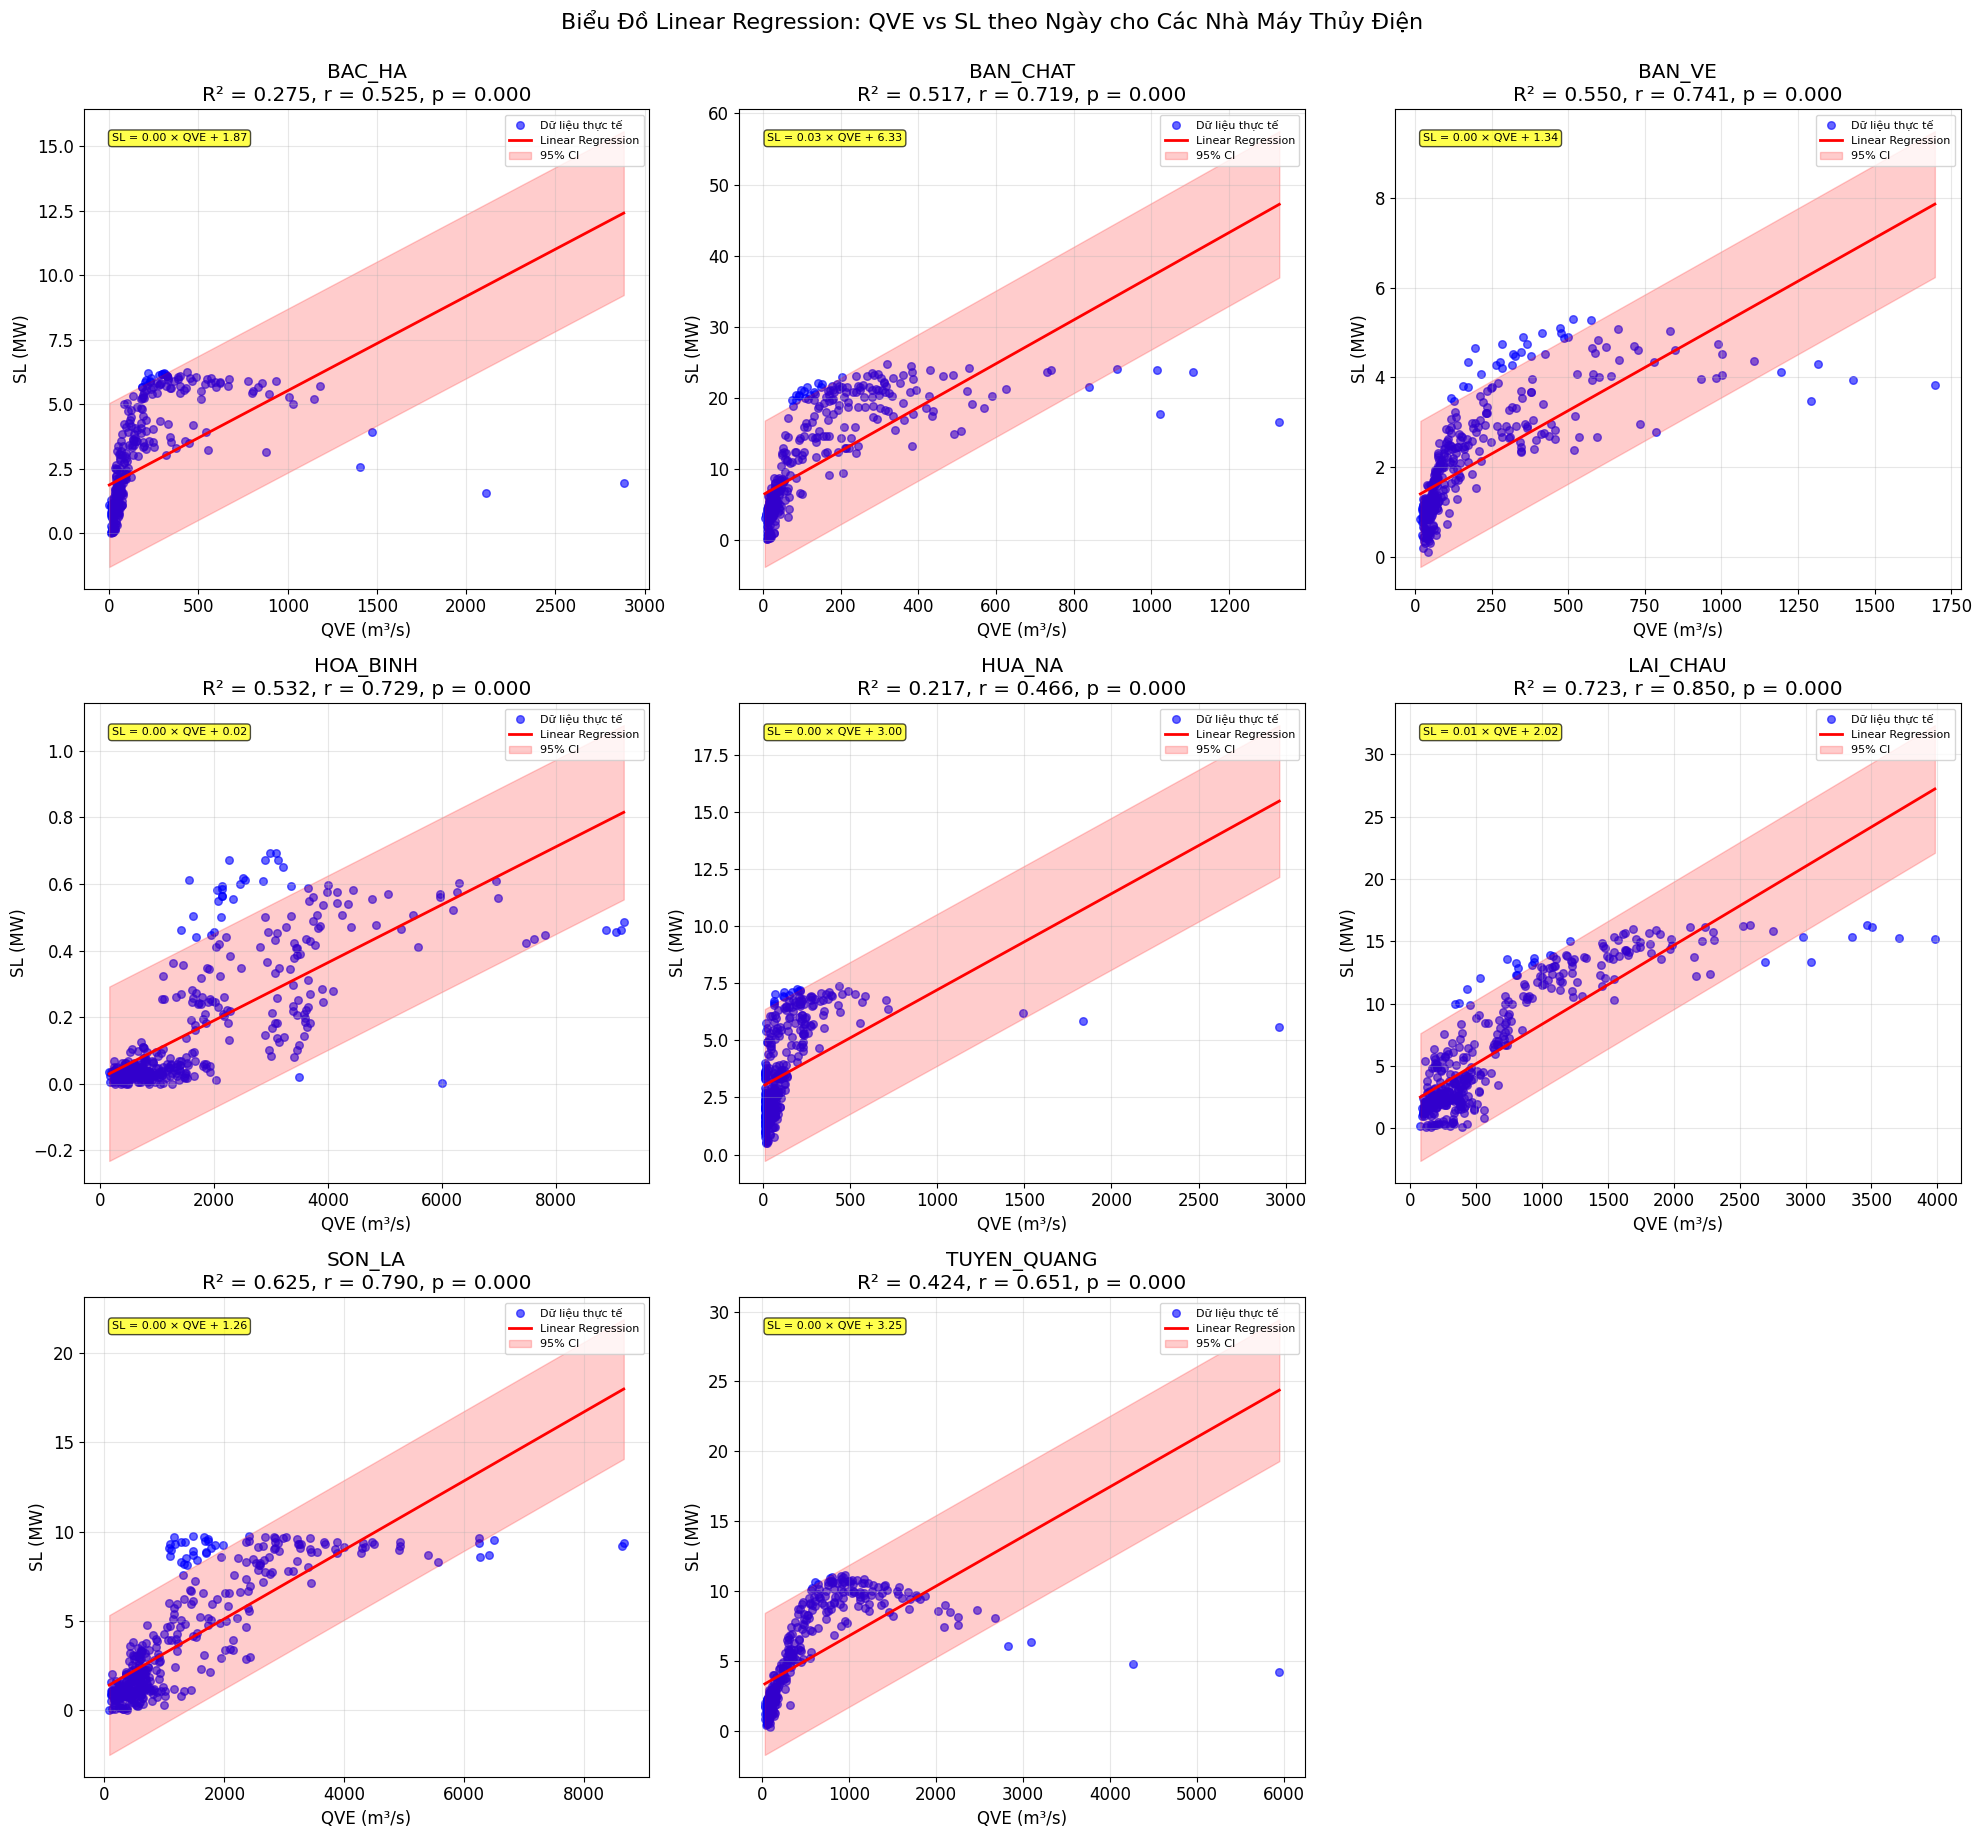

In [27]:
# Biểu đồ Linear Regression QVE vs SL theo ngày cho từng TD_THAMCHIEU
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

# Lọc dữ liệu hợp lệ
data_clean = data.dropna(subset=['QVE', 'SL', 'TD_THAMCHIEU'])

# Lấy danh sách nhà máy
power_plants = data_clean['TD_THAMCHIEU'].unique()
print(f"Các nhà máy: {power_plants}")

# Thiết lập subplot
n_plants = len(power_plants)
cols = 3
rows = (n_plants + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

# Dictionary để lưu kết quả
results = {}

for idx, plant in enumerate(power_plants):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    
    # Lọc dữ liệu cho nhà máy
    plant_data = data_clean[data_clean['TD_THAMCHIEU'] == plant].copy()
    
    if len(plant_data) < 2:
        ax.text(0.5, 0.5, f'Không đủ dữ liệu\ncho {plant}', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{plant}')
        continue
    
    # Chuẩn bị dữ liệu cho regression
    x = plant_data['QVE'].values.reshape(-1, 1)
    y = plant_data['SL'].values
    
    # Loại bỏ NaN nếu có
    mask = ~(np.isnan(x.flatten()) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    if len(x) < 2:
        ax.text(0.5, 0.5, f'Không đủ dữ liệu hợp lệ\ncho {plant}', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{plant}')
        continue
    
    # Tính Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(x.reshape(-1, 1), y)
    y_pred = lr_model.predict(x.reshape(-1, 1))
    
    # Tính các chỉ số thống kê
    r2 = r2_score(y, y_pred)
    pearson_corr, p_value = stats.pearsonr(x.flatten(), y)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    
    # Lưu kết quả
    results[plant] = {
        'r2': r2,
        'correlation': pearson_corr,
        'p_value': p_value,
        'slope': slope,
        'intercept': intercept,
        'n_samples': len(x)
    }
    
    # Vẽ scatter plot
    ax.scatter(x, y, alpha=0.6, s=30, color='blue', label='Dữ liệu thực tế')
    
    # Vẽ regression line
    x_range = np.linspace(x.min(), x.max(), 100)
    y_range = lr_model.predict(x_range.reshape(-1, 1))
    ax.plot(x_range, y_range, 'r-', linewidth=2, label='Linear Regression')
    
    # Thêm confidence interval (95%)
    from scipy.stats import t
    n = len(x)
    if n > 2:
        y_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
        t_val = t.ppf(0.975, n - 2)
        
        y_upper = y_range + t_val * y_err
        y_lower = y_range - t_val * y_err
        ax.fill_between(x_range, y_lower, y_upper, alpha=0.2, color='red', 
                       label='95% CI')
    
    # Thiết lập tiêu đề và labels
    ax.set_title(f'{plant}\nR² = {r2:.3f}, r = {pearson_corr:.3f}, p = {p_value:.3f}', 
                color='black')
    ax.set_xlabel('QVE (m³/s)', color='black')
    ax.set_ylabel('SL (MW)', color='black')
    ax.tick_params(colors='black')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Thêm phương trình regression
    equation = f'SL = {slope:.2f} × QVE + {intercept:.2f}'
    ax.text(0.05, 0.95, equation, transform=ax.transAxes, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
           fontsize=8, verticalalignment='top')

# Ẩn các subplot trống
for idx in range(n_plants, rows * cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.suptitle('Biểu Đồ Linear Regression: QVE vs SL theo Ngày cho Các Nhà Máy Thủy Điện', 
             fontsize=16, y=1.02, color='black')

# In bảng kết quả
print("\n" + "="*80)
print("KẾT QUẢ PHÂN TÍCH LINEAR REGRESSION")
print("="*80)
results_data = pd.DataFrame(results).T
results_data['correlation_strength'] = results_data['correlation'].apply(
    lambda x: 'Rất mạnh' if abs(x) >= 0.9 else
              'Mạnh' if abs(x) >= 0.7 else
              'Trung bình' if abs(x) >= 0.5 else
              'Yếu' if abs(x) >= 0.3 else 'Rất yếu'
)
results_data['significance'] = results_data['p_value'].apply(
    lambda x: 'Có ý nghĩa' if x < 0.05 else 'Không có ý nghĩa'
)

print(results_data[['correlation', 'r2', 'p_value', 'slope', 'correlation_strength', 'significance']].round(4))

plt.show()


Sử dụng cột ngày: Ngày
Dữ liệu sau khi tổng hợp theo tháng: 112 records
Khoảng thời gian: 2024-04 đến 2025-05
Các nhà máy: ['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG']

KẾT QUẢ PHÂN TÍCH LINEAR REGRESSION THEO THÁNG
             n_months  correlation     r2  p_value  slope   avg_qve   avg_sl  \
BAC_HA           14.0        0.913  0.834    0.000  0.287   146.703   71.002   
BAN_CHAT         14.0        0.958  0.918    0.000  1.687   115.624  293.118   
BAN_VE           14.0        0.869  0.755    0.000  0.160   168.213   58.687   
HOA_BINH         14.0        0.925  0.855    0.000  0.003  1714.976    4.896   
HUA_NA           14.0        0.758  0.575    0.002  0.327   106.422  101.226   
LAI_CHAU         14.0        0.951  0.904    0.000  0.237   623.849  178.876   
SON_LA           14.0        0.931  0.866    0.000  0.079  1217.140  107.274   
TUYEN_QUANG      14.0        0.950  0.903    0.000  0.206   450.208  143.480   

            correlatio

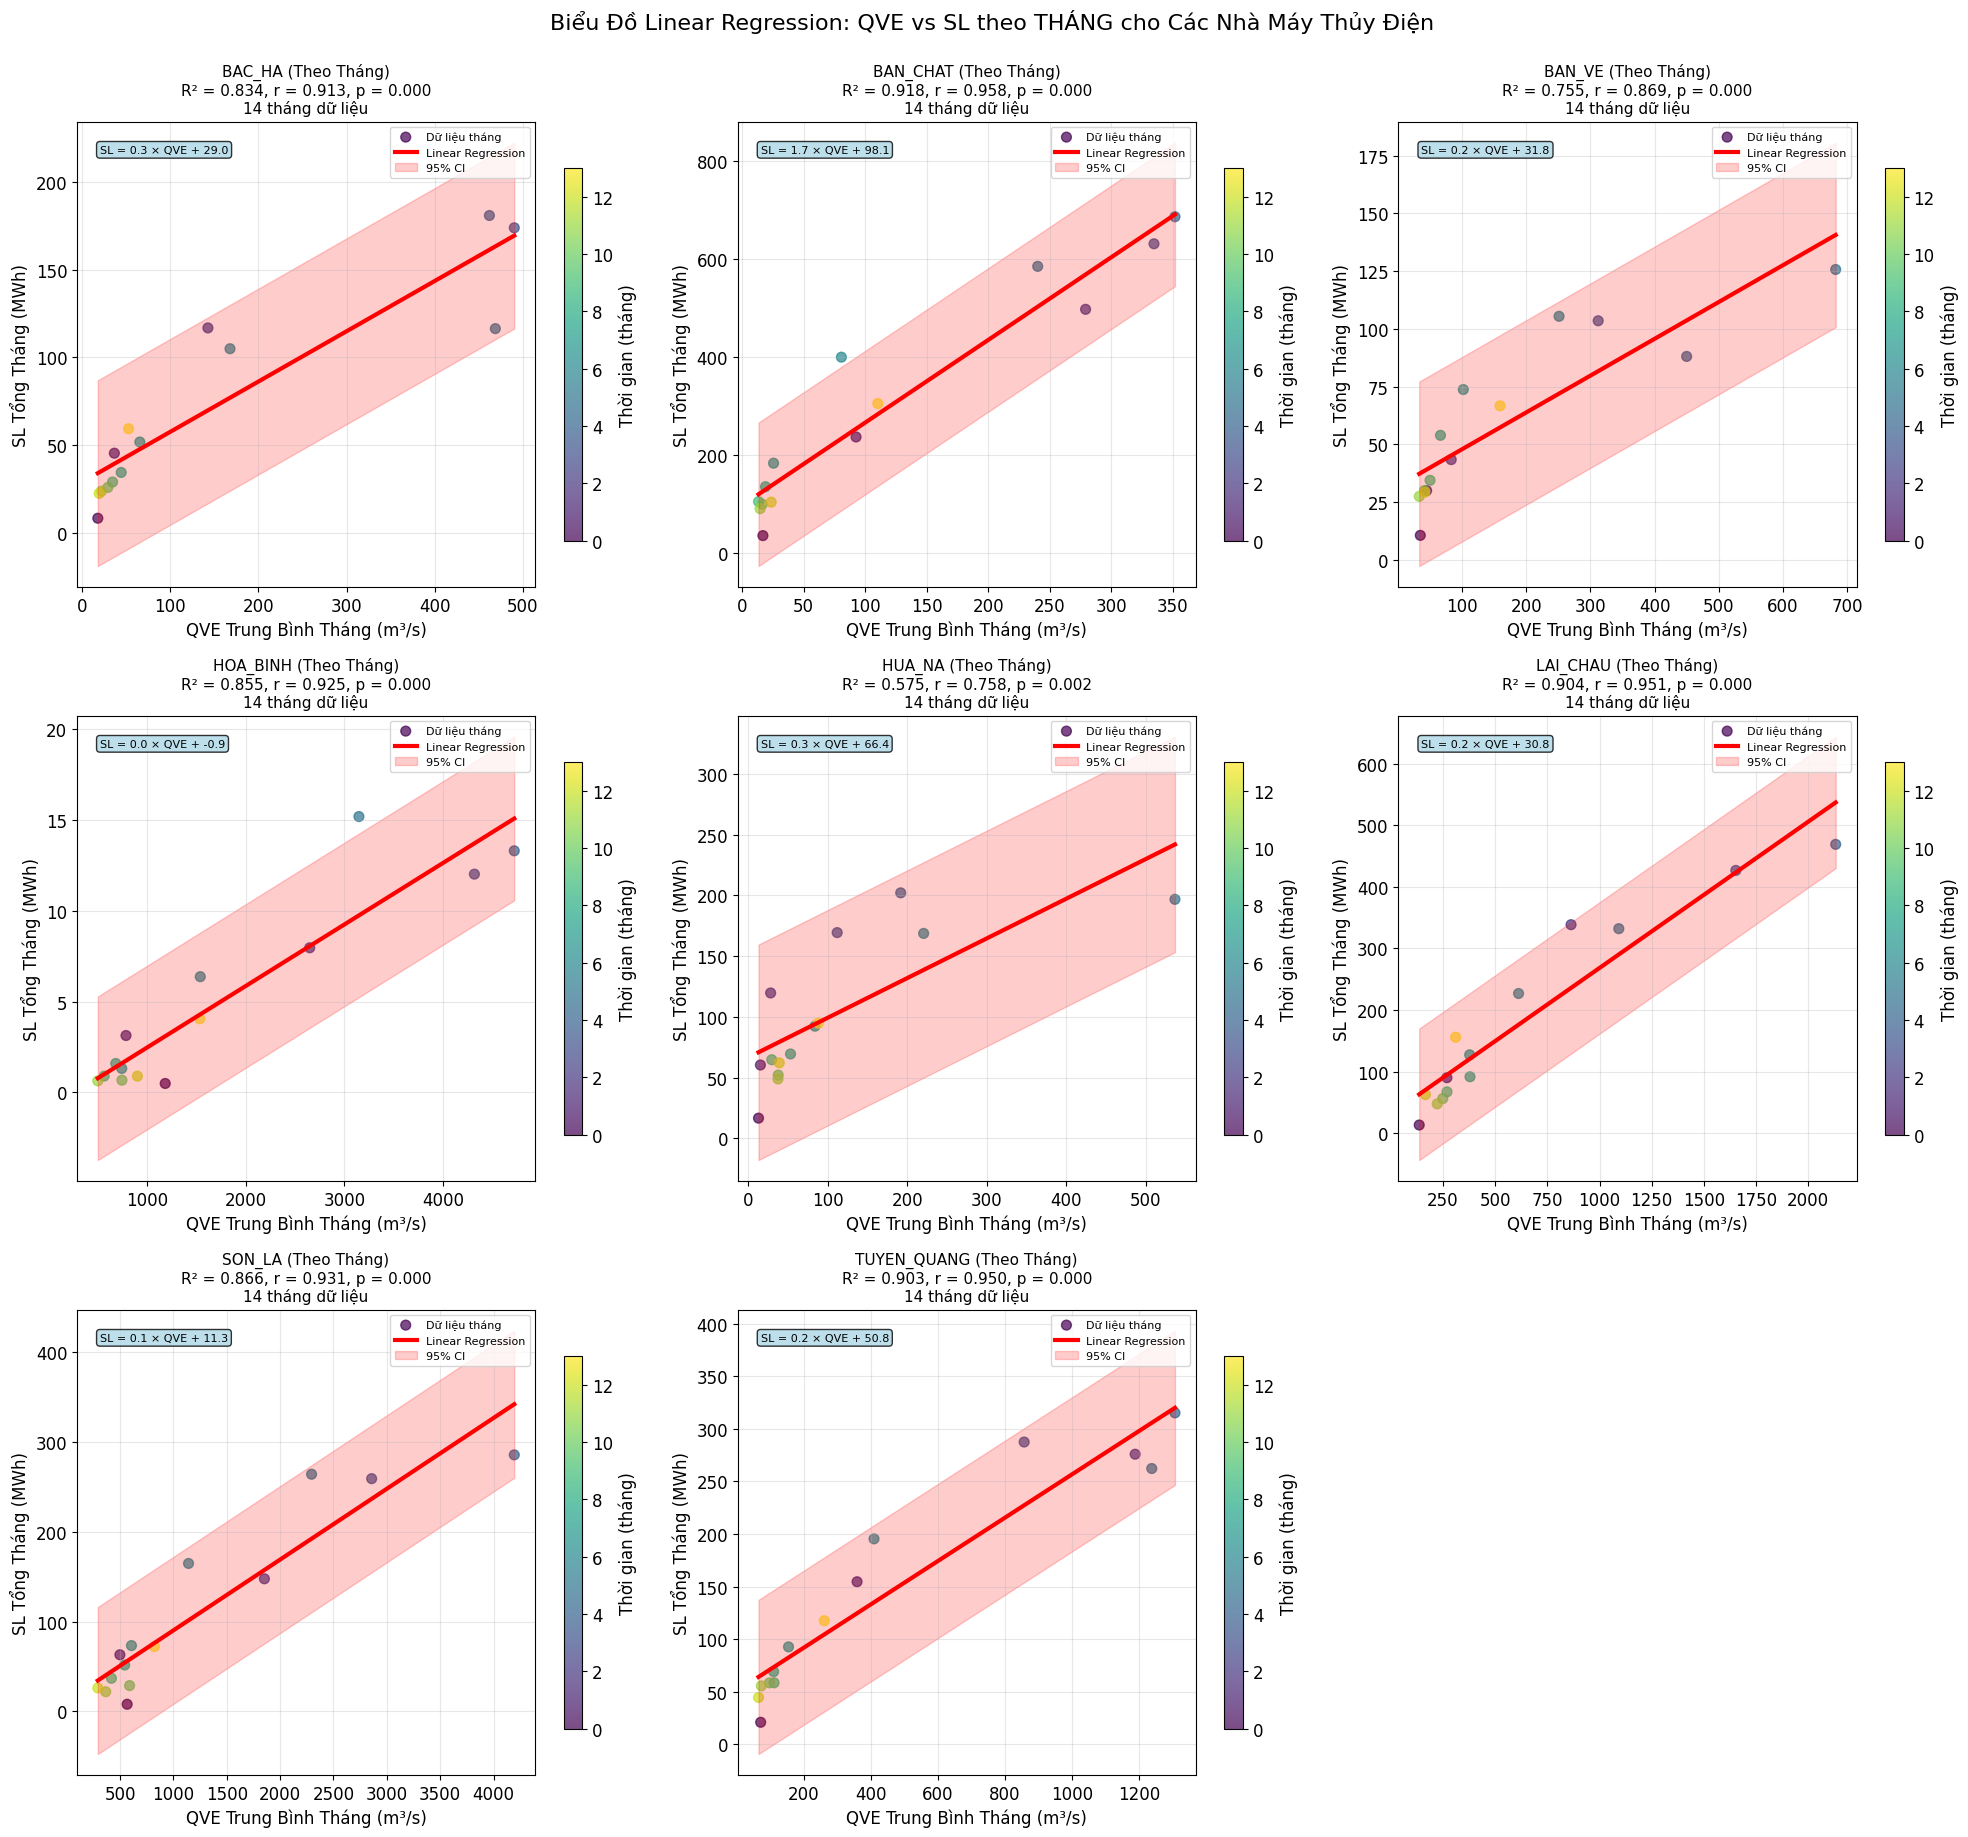

In [33]:
# Biểu đồ Linear Regression QVE vs SL theo THÁNG cho từng TD_THAMCHIEU
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

# Tìm cột ngày (có thể là 'Ngày' hoặc 'NGAY')
date_col = None
for col in data.columns:
    if 'ngày' in col.lower() or 'ngay' in col.lower() or 'date' in col.lower():
        date_col = col
        break

if date_col is None:
    print("Không tìm thấy cột ngày!")
else:
    print(f"Sử dụng cột ngày: {date_col}")
    
    # Chuyển đổi cột ngày và thêm cột tháng-năm
    data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
    data['Year_Month'] = data[date_col].dt.to_period('M')
    
    # Tổng hợp dữ liệu theo tháng cho từng nhà máy
    monthly_data = data.groupby(['TD_THAMCHIEU', 'Year_Month']).agg({
        'QVE': 'mean',  # Trung bình QVE trong tháng
        'SL': 'sum'     # Tổng SL trong tháng
    }).reset_index()
    
    # Lọc dữ liệu hợp lệ
    monthly_clean = monthly_data.dropna(subset=['QVE', 'SL'])
    
    print(f"Dữ liệu sau khi tổng hợp theo tháng: {len(monthly_clean)} records")
    print(f"Khoảng thời gian: {monthly_clean['Year_Month'].min()} đến {monthly_clean['Year_Month'].max()}")
    
    # Lấy danh sách nhà máy
    power_plants = monthly_clean['TD_THAMCHIEU'].unique()
    print(f"Các nhà máy: {power_plants}")
    
    # Thiết lập subplot
    n_plants = len(power_plants)
    cols = 3
    rows = (n_plants + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Dictionary để lưu kết quả
    monthly_results = {}
    
    for idx, plant in enumerate(power_plants):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        # Lọc dữ liệu cho nhà máy
        plant_data = monthly_clean[monthly_clean['TD_THAMCHIEU'] == plant].copy()
        
        if len(plant_data) < 3:  # Cần ít nhất 3 tháng dữ liệu
            ax.text(0.5, 0.5, f'Không đủ dữ liệu\ncho {plant}\n({len(plant_data)} tháng)', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{plant}')
            continue
        
        # Chuẩn bị dữ liệu cho regression
        x = plant_data['QVE'].values.reshape(-1, 1)
        y = plant_data['SL'].values
        
        # Loại bỏ NaN nếu có
        mask = ~(np.isnan(x.flatten()) | np.isnan(y))
        x = x[mask]
        y = y[mask]
        
        if len(x) < 3:
            ax.text(0.5, 0.5, f'Không đủ dữ liệu hợp lệ\ncho {plant}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{plant}')
            continue
        
        # Tính Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(x.reshape(-1, 1), y)
        y_pred = lr_model.predict(x.reshape(-1, 1))
        
        # Tính các chỉ số thống kê
        r2 = r2_score(y, y_pred)
        pearson_corr, p_value = stats.pearsonr(x.flatten(), y)
        slope = lr_model.coef_[0]
        intercept = lr_model.intercept_
        
        # Lưu kết quả
        monthly_results[plant] = {
            'r2': r2,
            'correlation': pearson_corr,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept,
            'n_months': len(x),
            'avg_qve': x.mean(),
            'avg_sl': y.mean()
        }
        
        # Vẽ scatter plot với màu sắc theo thời gian
        scatter = ax.scatter(x, y, alpha=0.7, s=50, 
                           c=range(len(x)), cmap='viridis', 
                           label='Dữ liệu tháng')
        
        # Vẽ regression line
        x_range = np.linspace(x.min(), x.max(), 100)
        y_range = lr_model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_range, 'r-', linewidth=3, label='Linear Regression')
        
        # Thêm confidence interval (95%)
        from scipy.stats import t
        n = len(x)
        if n > 2:
            y_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
            t_val = t.ppf(0.975, n - 2)
            
            y_upper = y_range + t_val * y_err
            y_lower = y_range - t_val * y_err
            ax.fill_between(x_range, y_lower, y_upper, alpha=0.2, color='red', 
                           label='95% CI')
        
        # Thiết lập tiêu đề và labels
        ax.set_title(f'{plant} (Theo Tháng)\nR² = {r2:.3f}, r = {pearson_corr:.3f}, p = {p_value:.3f}\n{len(x)} tháng dữ liệu', 
                    color='black', fontsize=11)
        ax.set_xlabel('QVE Trung Bình Tháng (m³/s)', color='black')
        ax.set_ylabel('SL Tổng Tháng (MWh)', color='black')
        ax.tick_params(colors='black')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Thêm phương trình regression
        equation = f'SL = {slope:.1f} × QVE + {intercept:.1f}'
        ax.text(0.05, 0.95, equation, transform=ax.transAxes, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
               fontsize=8, verticalalignment='top')
        
        # Thêm colorbar cho scatter plot
        if len(x) > 5:  # Chỉ thêm colorbar nếu có đủ dữ liệu
            plt.colorbar(scatter, ax=ax, label='Thời gian (tháng)', shrink=0.8)
    
    # Ẩn các subplot trống
    for idx in range(n_plants, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Biểu Đồ Linear Regression: QVE vs SL theo THÁNG cho Các Nhà Máy Thủy Điện', 
                 fontsize=16, y=1.02, color='black')
    
    # In bảng kết quả theo tháng
    print("\n" + "="*90)
    print("KẾT QUẢ PHÂN TÍCH LINEAR REGRESSION THEO THÁNG")
    print("="*90)
    
    if monthly_results:
        results_data = pd.DataFrame(monthly_results).T
        results_data['correlation_strength'] = results_data['correlation'].apply(
            lambda x: 'Rất mạnh' if abs(x) >= 0.85 else
                      'Mạnh' if abs(x) >= 0.65 else
                      'Trung bình' if abs(x) >= 0.45 else
                      'Yếu' if abs(x) >= 0.25 else 'Rất yếu'
        )
        results_data['significance'] = results_data['p_value'].apply(
            lambda x: 'Có ý nghĩa' if x < 0.05 else 'Không có ý nghĩa'
        )
        
        # Hiển thị kết quả với định dạng đẹp
        display_cols = ['n_months', 'correlation', 'r2', 'p_value', 'slope', 
                       'avg_qve', 'avg_sl', 'correlation_strength', 'significance']
        print(results_data[display_cols].round(3))
        
        # Thống kê tổng quan
        print(f"\nTHỐNG KÊ TỔNG QUAN:")
        print(f"- Số nhà máy có tương quan mạnh (|r| ≥ 0.65): {sum(abs(results_data['correlation']) >= 0.65)}")
        print(f"- Số nhà máy có ý nghĩa thống kê (p < 0.05): {sum(results_data['p_value'] < 0.05)}")
        print(f"- R² trung bình: {results_data['r2'].mean():.3f}")
        print(f"- Correlation trung bình: {results_data['correlation'].mean():.3f}")
        
        # Nhà máy có tương quan cao nhất
        best_plant = results_data.loc[results_data['correlation'].abs().idxmax()]
        print(f"- Nhà máy có tương quan cao nhất: {best_plant.name} (r = {best_plant['correlation']:.3f})")
    
    plt.show()

Sử dụng cột ngày: Ngày
Dữ liệu sau khi tổng hợp theo tuần: 472 records
Khoảng thời gian: 2024-04-15/2024-04-21 đến 2025-05-26/2025-06-01
Các nhà máy: ['BAC_HA' 'BAN_CHAT' 'BAN_VE' 'HOA_BINH' 'HUA_NA' 'LAI_CHAU' 'SON_LA'
 'TUYEN_QUANG']

KẾT QUẢ PHÂN TÍCH LINEAR REGRESSION THEO TUẦN
             n_weeks  correlation     r2  p_value  slope   avg_qve  avg_sl  \
BAC_HA          59.0        0.667  0.445      0.0  0.038   151.763  16.848   
BAN_CHAT        59.0        0.828  0.686      0.0  0.285   119.651  69.554   
BAN_VE          59.0        0.818  0.670      0.0  0.032   173.988  13.926   
HOA_BINH        59.0        0.836  0.699      0.0  0.001  1738.982   1.162   
HUA_NA          59.0        0.658  0.434      0.0  0.053   109.726  24.020   
LAI_CHAU        59.0        0.884  0.782      0.0  0.047   643.400  42.445   
SON_LA          59.0        0.847  0.718      0.0  0.015  1242.729  25.455   
TUYEN_QUANG     59.0        0.794  0.630      0.0  0.034   464.433  34.046   

            co

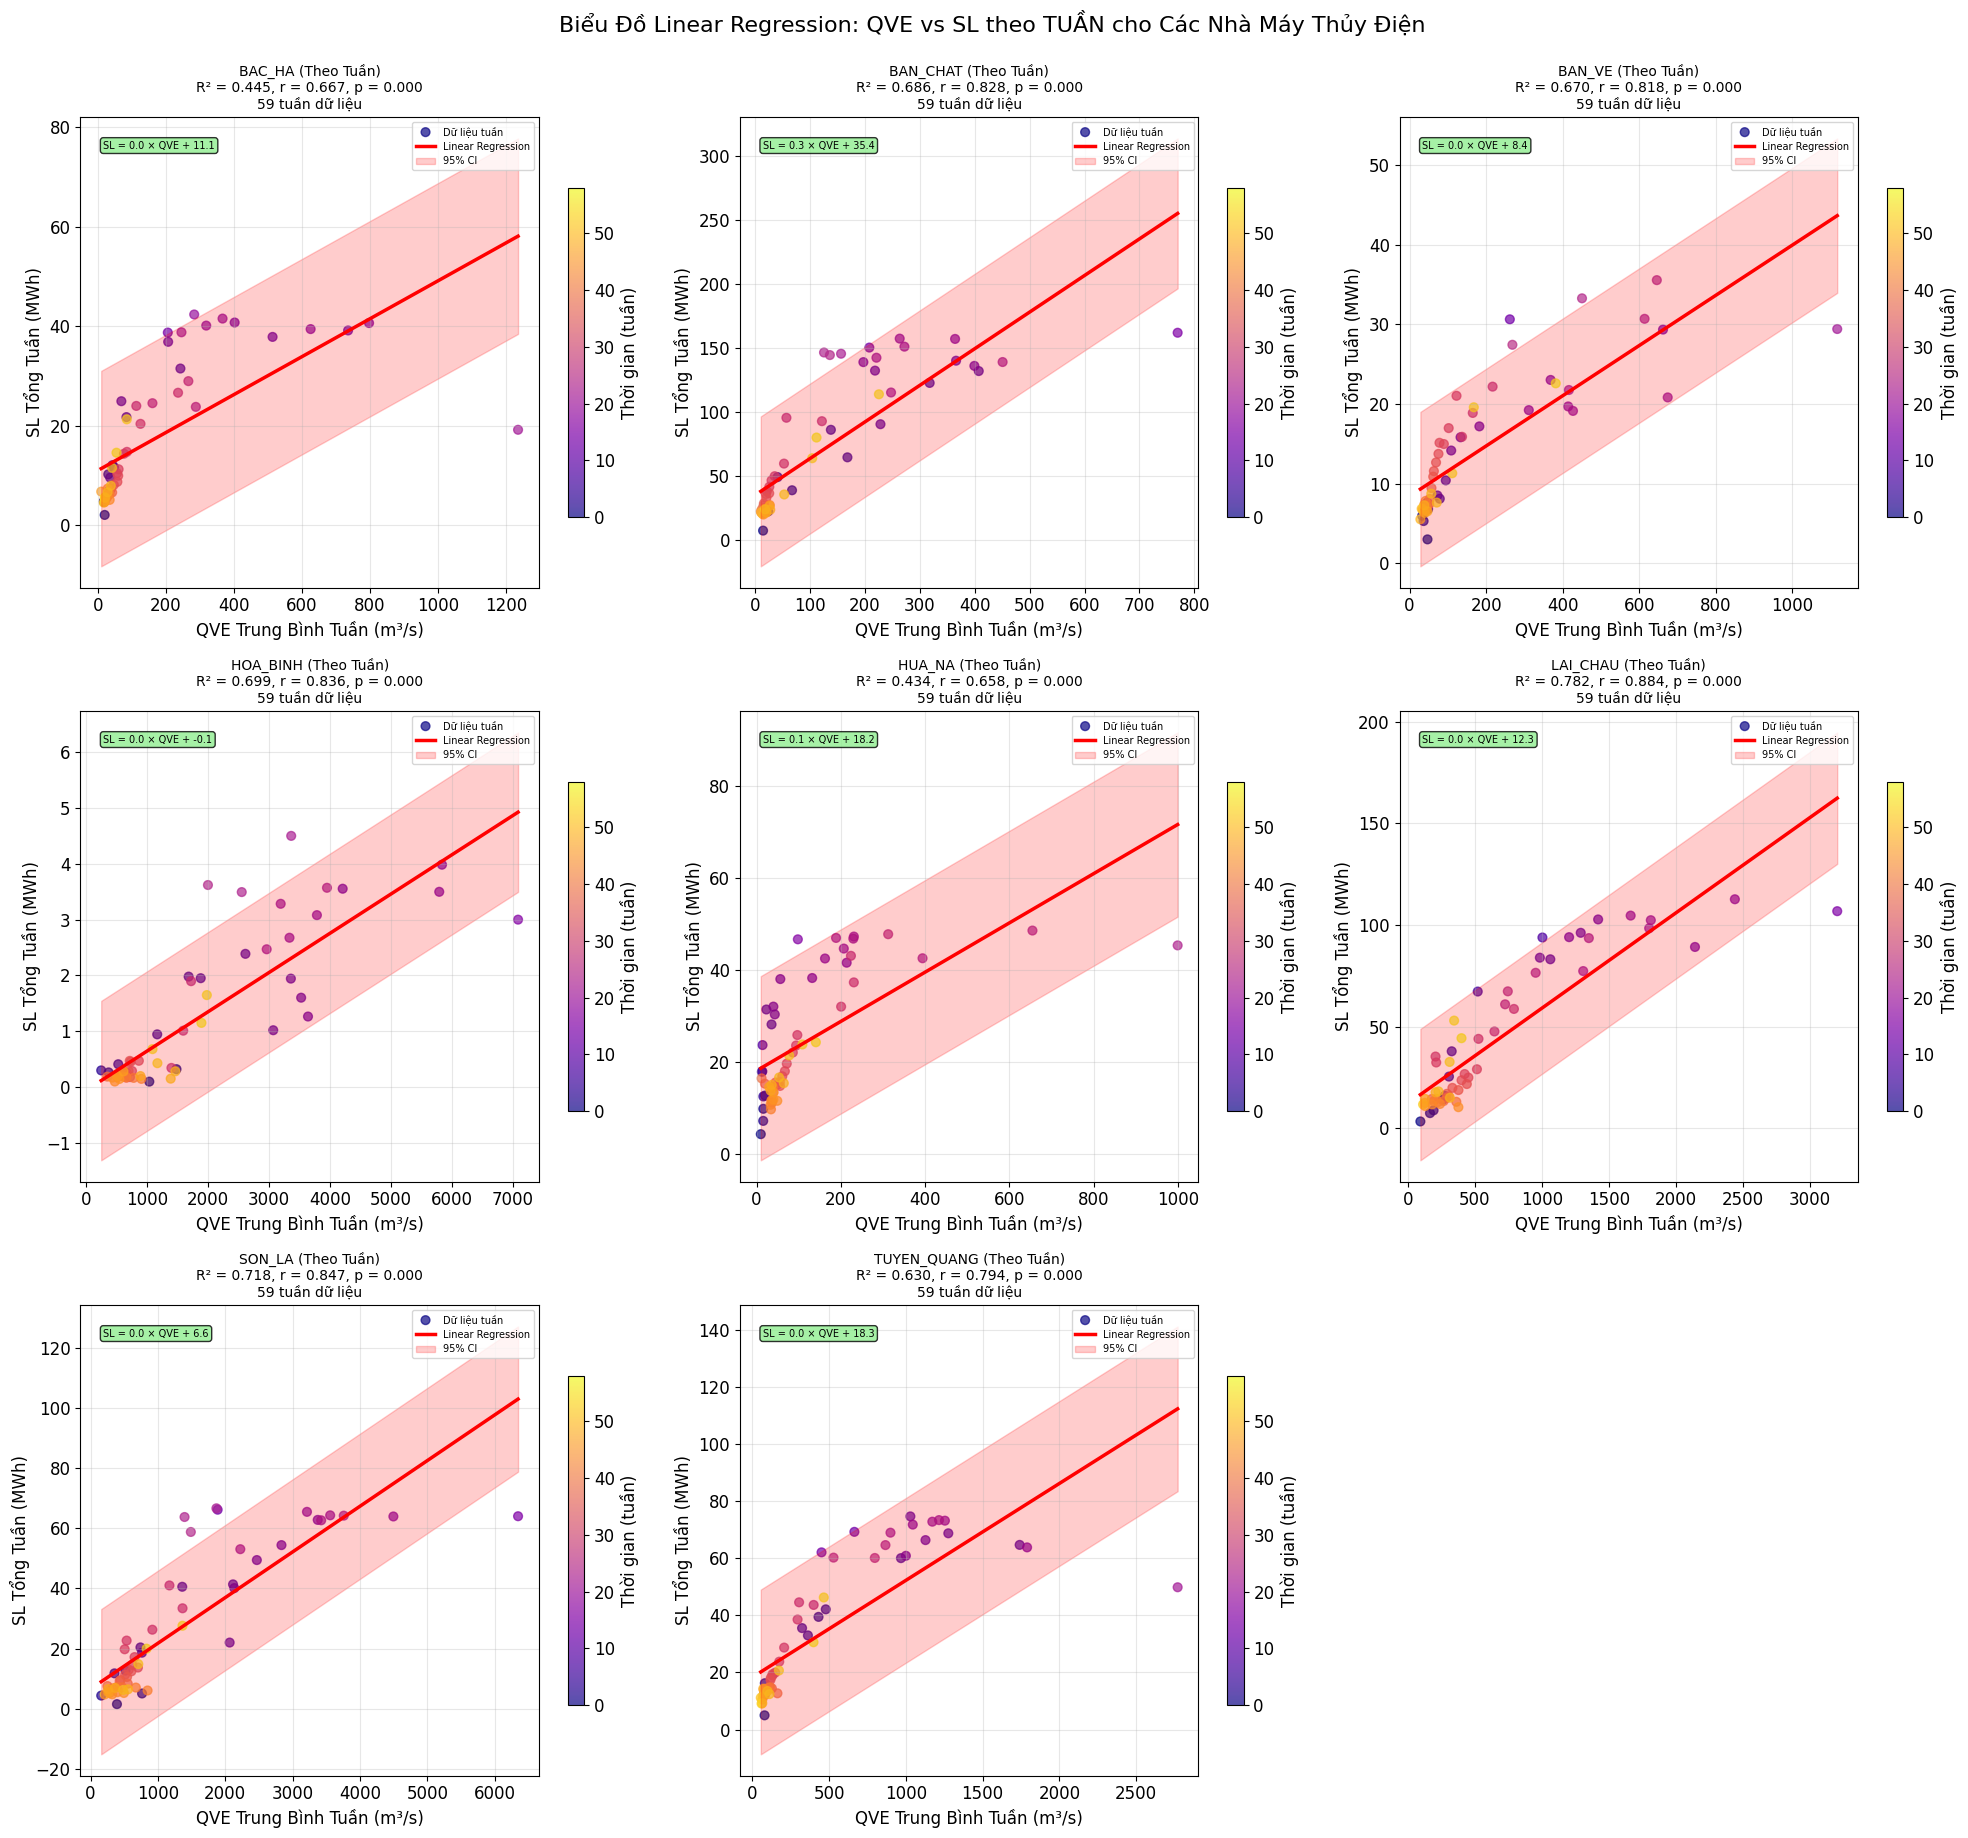

In [34]:
# Biểu đồ Linear Regression QVE vs SL theo TUẦN cho từng TD_THAMCHIEU
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

# Tìm cột ngày (có thể là 'Ngày' hoặc 'NGAY')
date_col = None
for col in data.columns:
    if 'ngày' in col.lower() or 'ngay' in col.lower() or 'date' in col.lower():
        date_col = col
        break

if date_col is None:
    print("Không tìm thấy cột ngày!")
else:
    print(f"Sử dụng cột ngày: {date_col}")
    
    # Chuyển đổi cột ngày và thêm cột tuần-năm
    data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
    data['Year_Week'] = data[date_col].dt.to_period('W')
    
    # Tổng hợp dữ liệu theo tuần cho từng nhà máy
    weekly_data = data.groupby(['TD_THAMCHIEU', 'Year_Week']).agg({
        'QVE': 'mean',  # Trung bình QVE trong tuần
        'SL': 'sum'     # Tổng SL trong tuần
    }).reset_index()
    
    # Lọc dữ liệu hợp lệ
    weekly_clean = weekly_data.dropna(subset=['QVE', 'SL'])
    
    print(f"Dữ liệu sau khi tổng hợp theo tuần: {len(weekly_clean)} records")
    print(f"Khoảng thời gian: {weekly_clean['Year_Week'].min()} đến {weekly_clean['Year_Week'].max()}")
    
    # Lấy danh sách nhà máy
    power_plants = weekly_clean['TD_THAMCHIEU'].unique()
    print(f"Các nhà máy: {power_plants}")
    
    # Thiết lập subplot
    n_plants = len(power_plants)
    cols = 3
    rows = (n_plants + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Dictionary để lưu kết quả
    weekly_results = {}
    
    for idx, plant in enumerate(power_plants):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        # Lọc dữ liệu cho nhà máy
        plant_data = weekly_clean[weekly_clean['TD_THAMCHIEU'] == plant].copy()
        
        if len(plant_data) < 5:  # Cần ít nhất 5 tuần dữ liệu
            ax.text(0.5, 0.5, f'Không đủ dữ liệu\ncho {plant}\n({len(plant_data)} tuần)', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{plant}')
            continue
        
        # Chuẩn bị dữ liệu cho regression
        x = plant_data['QVE'].values.reshape(-1, 1)
        y = plant_data['SL'].values
        
        # Loại bỏ NaN nếu có
        mask = ~(np.isnan(x.flatten()) | np.isnan(y))
        x = x[mask]
        y = y[mask]
        
        if len(x) < 5:
            ax.text(0.5, 0.5, f'Không đủ dữ liệu hợp lệ\ncho {plant}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{plant}')
            continue
        
        # Tính Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(x.reshape(-1, 1), y)
        y_pred = lr_model.predict(x.reshape(-1, 1))
        
        # Tính các chỉ số thống kê
        r2 = r2_score(y, y_pred)
        pearson_corr, p_value = stats.pearsonr(x.flatten(), y)
        slope = lr_model.coef_[0]
        intercept = lr_model.intercept_
        
        # Lưu kết quả
        weekly_results[plant] = {
            'r2': r2,
            'correlation': pearson_corr,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept,
            'n_weeks': len(x),
            'avg_qve': x.mean(),
            'avg_sl': y.mean()
        }
        
        # Vẽ scatter plot với màu sắc theo thời gian
        scatter = ax.scatter(x, y, alpha=0.7, s=40, 
                           c=range(len(x)), cmap='plasma', 
                           label='Dữ liệu tuần')
        
        # Vẽ regression line
        x_range = np.linspace(x.min(), x.max(), 100)
        y_range = lr_model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_range, 'r-', linewidth=2.5, label='Linear Regression')
        
        # Thêm confidence interval (95%)
        from scipy.stats import t
        n = len(x)
        if n > 2:
            y_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
            t_val = t.ppf(0.975, n - 2)
            
            y_upper = y_range + t_val * y_err
            y_lower = y_range - t_val * y_err
            ax.fill_between(x_range, y_lower, y_upper, alpha=0.2, color='red', 
                           label='95% CI')
        
        # Thiết lập tiêu đề và labels
        ax.set_title(f'{plant} (Theo Tuần)\nR² = {r2:.3f}, r = {pearson_corr:.3f}, p = {p_value:.3f}\n{len(x)} tuần dữ liệu', 
                    color='black', fontsize=10)
        ax.set_xlabel('QVE Trung Bình Tuần (m³/s)', color='black')
        ax.set_ylabel('SL Tổng Tuần (MWh)', color='black')
        ax.tick_params(colors='black')
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)
        
        # Thêm phương trình regression
        equation = f'SL = {slope:.1f} × QVE + {intercept:.1f}'
        ax.text(0.05, 0.95, equation, transform=ax.transAxes, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8),
               fontsize=7, verticalalignment='top')
        
        # Thêm colorbar cho scatter plot
        if len(x) > 8:  # Chỉ thêm colorbar nếu có đủ dữ liệu
            plt.colorbar(scatter, ax=ax, label='Thời gian (tuần)', shrink=0.7)
    
    # Ẩn các subplot trống
    for idx in range(n_plants, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Biểu Đồ Linear Regression: QVE vs SL theo TUẦN cho Các Nhà Máy Thủy Điện', 
                 fontsize=16, y=1.02, color='black')
    
    # In bảng kết quả theo tuần
    print("\n" + "="*90)
    print("KẾT QUẢ PHÂN TÍCH LINEAR REGRESSION THEO TUẦN")
    print("="*90)
    
    if weekly_results:
        results_data = pd.DataFrame(weekly_results).T
        results_data['correlation_strength'] = results_data['correlation'].apply(
            lambda x: 'Rất mạnh' if abs(x) >= 0.8 else
                      'Mạnh' if abs(x) >= 0.6 else
                      'Trung bình' if abs(x) >= 0.4 else
                      'Yếu' if abs(x) >= 0.2 else 'Rất yếu'
        )
        results_data['significance'] = results_data['p_value'].apply(
            lambda x: 'Có ý nghĩa' if x < 0.05 else 'Không có ý nghĩa'
        )
        
        # Hiển thị kết quả với định dạng đẹp
        display_cols = ['n_weeks', 'correlation', 'r2', 'p_value', 'slope', 
                       'avg_qve', 'avg_sl', 'correlation_strength', 'significance']
        print(results_data[display_cols].round(3))
        
        # Thống kê tổng quan
        print(f"\nTHỐNG KÊ TỔNG QUAN:")
        print(f"- Số nhà máy có tương quan mạnh (|r| ≥ 0.6): {sum(abs(results_data['correlation']) >= 0.6)}")
        print(f"- Số nhà máy có ý nghĩa thống kê (p < 0.05): {sum(results_data['p_value'] < 0.05)}")
        print(f"- R² trung bình: {results_data['r2'].mean():.3f}")
        print(f"- Correlation trung bình: {results_data['correlation'].mean():.3f}")
        
        # Nhà máy có tương quan cao nhất
        best_plant = results_data.loc[results_data['correlation'].abs().idxmax()]
        print(f"- Nhà máy có tương quan cao nhất: {best_plant.name} (r = {best_plant['correlation']:.3f})")
        
        # So sánh với phân tích theo ngày
        print(f"\nSO SÁNH VỚI PHÂN TÍCH THEO NGÀY:")
        print(f"- Phân tích theo tuần có xu hướng cho kết quả ổn định hơn do giảm nhiễu ngắn hạn")
        print(f"- Dữ liệu được tổng hợp giúp làm nổi bật xu hướng dài hạn")
    
    plt.show()